### Mehregan Nazarmohsenifakori, mehrega.nazarmohseni@studio.unibo.it

In [ ]:
!pip install causalgen
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, r2_score
from causalgen import Generator
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, GridSearch
from fairlearn.postprocessing import ThresholdOptimizer


## Project Introduction

In this project, we explore a very real problem in machine learning: **what happens when the data is biased?** More importantly — **what happens when we try to fix it?**

To answer that, we built a synthetic data generator that allows us to simulate different types of bias (like additive, multiplicative, nonlinear, and interaction-based). This way, we have full control over the data — and access to the true, unbiased labels — so we can clearly see how fairness enforcement affect the results.

We tested a variety of **fairness-enhancing techniques** from three main categories:

-  **Pre-processing:** clean the data before training (Re-weighting, Label Massaging)  
- **In-processing:** change how the model learns (Exponentiated Gradient, Grid Search)  
- **Post-processing:** adjust predictions after training (Threshold Optimization)

The goal was to understand the **trade-off between fairness and accuracy**, especially when enforcing fairness might reduce performance — or in some cases, actually help it.

### Explanation of `build`

The `build` function is our synthetic “bias factory.” It generates tabular data with:
- A hidden, unbiased ground-truth label `uy`.
- An observed, biased label `y`.
- One or two input features (`x0`, `x1`) that carry bias in controlled ways.
- A protected attribute `b` whose relationship to the features drives the bias.

By adjusting its parameters, we can simulate a variety of bias scenarios—from small additive shifts to complex interaction effects.

---

#### Function arguments

- `seed: int = 0`  
  Sets the random seed for reproducibility.

- `binomial: bool = True`  
  If `true`, the protected attribute `b` is binary (0/1). If `false`, `b` is drawn continuously from a Gaussian.

- `bivariate: bool = True`  
  If `true`, generates two biased features (`x0`, `x1`). If `false`, only `x0`.

- `bias_strength: float = 1.0`  
  Controls how strongly `b` distorts the features. Larger values → larger shifts or scale changes.

- `bias_type: str = 'additive'`  
  - **`additive`**:  
    ```python
    x0 = u0 + bias_strength * (b == 0 ? +1 : -1)
    ```
  - **`multiplicative`**:  
    ```python
    x0 = u0 * (b == 0 ? 1 + bias_strength : 1 - bias_strength)
    ```
  - **`nonlinear`**:  
    ```python
    x0 = u0 + bias_strength * (b == 0 ? +1 : -1) * sign(u0)
    ```

- `interaction_bias: bool = False`  
  When `true` (and `binomial=True`), the observed label `y` includes an extra interaction term:
  ```python
  y = ( x0 + x1 + bias_strength * b * x0 * x1 + n >= 0 )


In [ ]:
def build(seed: int = 0, binomial: bool = True, bivariate: bool = True,
                  bias_strength: float = 1.0, bias_type: str = 'additive',
                  interaction_bias: bool = False):

    generator = Generator(seed=seed)

    # Unbiased input feature u0
    generator.normal(mu=0, sigma=1, name='u0', hidden=True)

    if binomial:
        # Binary protected attribute
        generator.binomial(p=0.5, name='b')

        # Apply different bias types
        if bias_type == 'additive':
            generator.descendant(
                lambda b, u0: u0 + bias_strength * np.where(b == 0, 1, -1),
                name='x0'
            )
        elif bias_type == 'multiplicative':
            generator.descendant(
                lambda b, u0: u0 * np.where(b == 0, 1 + bias_strength, 1 - bias_strength),
                name='x0'
            )
        elif bias_type == 'nonlinear':
            generator.descendant(
                lambda b, u0: u0 + bias_strength * np.where(b == 0, 1, -1) * np.sign(u0),
                name='x0'
            )
        else:
            raise ValueError(f"Unknown bias_type: {bias_type}")

        if bivariate:
            # Unbiased second feature
            generator.normal(mu=0, sigma=1, name='u1', hidden=True)

            if bias_type == 'additive':
                generator.descendant(
                    lambda b, u1: u1 + bias_strength * 0.8 * np.where(b == 0, -1, 1),
                    name='x1'
                )
            elif bias_type == 'multiplicative':
                generator.descendant(
                    lambda b, u1: u1 * np.where(b == 0, 2, 0.5) ** bias_strength,
                    name='x1'
                )
            elif bias_type == 'nonlinear':
                generator.descendant(
                    lambda b, u1: u1 + bias_strength * np.where(b == 0, -0.5, 0.5) * (u1 ** 2),
                    name='x1'
                )
    else:
        # Continuous protected attribute (bias)
        generator.normal(mu=0, sigma=1, name='b')

        # Biased input feature x0 (additive bias)
        generator.descendant(
            lambda b, u0: 1.8 * u0 + bias_strength * 1.5 * b,
            name='x0'
        )

        if bivariate:
            # Unbiased input feature u1
            generator.normal(mu=0, sigma=1, name='u1', hidden=True)
            # Biased input feature x1 (additive bias)
            generator.descendant(
                lambda b, u1: 1.6 * u1 + bias_strength * 1.7 * b,
                name='x1'
            )

    # Output noise
    generator.noise(amount=1.0, name='n', hidden=True)

    # Generate outcomes
    if bivariate:
        if interaction_bias and binomial:
            # Bias affects feature interactions
            generator.descendant(
                lambda u0, u1, n: u0 + u1 + n >= 0,
                name='uy'
            )
            generator.descendant(
                lambda x0, x1, b, n: x0 + x1 + bias_strength * b * x0 * x1 + n >= 0,
                name='y'
            )
        else:
            # Standard case
            generator.descendant(
                lambda u0, u1, n: u0 + u1 + n >= 0,
                name='uy'
            )
            generator.descendant(
                lambda x0, x1, n: x0 + x1 + n >= 0,
                name='y'
            )
    else:
        generator.descendant(
            lambda u0, n: u0 + n >= 0,
            name='uy'
        )
        generator.descendant(
            lambda x0, n: x0 + n >= 0,
            name='y'
        )

    return generator

### Bias Scenarios

Below are the six synthetic bias settings we’ll sweep through. Each setting tweaks how the protected attribute `b` distorts the features and labels.

---

### 1. `mild_additive`
- **binomial:** `True` (binary protected group)
- **bias_strength:** `0.5`  
  A small additive shift of ±0.5 is applied to each feature depending on group.
- **bias_type:** `additive`  
  Features are offset by +0.5 when `b=0` and –0.5 when `b=1`.
- **bivariate:** `True`  
  Two biased features (`x0` and `x1`) are generated.

> **Use case:** Study a low-bias regime where group differences in feature means are gentle (~0.5 units).

---

### 2. `severe_additive`
- **binomial:** `True`
- **bias_strength:** `2.0`  
  A large additive shift of ±2.0 units.
- **bias_type:** `additive`
- **bivariate:** `True`

> **Use case:** Simulate an extreme bias scenario where one group’s feature distributions are shifted far apart.

---

### 3. `mild_multiplicative`
- **binomial:** `True`
- **bias_strength:** `0.3`  
  A mild scaling effect.
- **bias_type:** `multiplicative`  
  Features for `b=0` are multiplied by `1 + 0.3 = 1.3`, and for `b=1` by `1 – 0.3 = 0.7`.
- **bivariate:** `True`

> **Use case:** Explore how small group-specific magnification or attenuation of features impacts bias.

---

### 4. `nonlinear_bias`
- **binomial:** `True`
- **bias_strength:** `1.0`
- **bias_type:** `nonlinear`  
  Applies a sign-dependent distortion:  
  ```python
  x0 = u0 + 1.0 * (b == 0 ? +1 : –1) * sign(u0)

---

### 5. `Interaction Bias`

- **Protected Attribute**: Binary  
- **Bias Strength**: `1.0`  
- **Bias Type**:  
  - **Additive on features**  
  - **Interaction on label**  
- **Bivariate**: `true`  
- **Interaction Flag**: `true`

**Feature Mechanism:**  
Same as `mild_additive`

**Label Mechanism:**

```python
y = ( x0 + x1 + 1.0 · b · x0 · x1 + noise ≥ 0 )
```

**When to use:**  
Use this when bias only **emerges through the interaction** of multiple features.


In [ ]:
bias_scenarios = {
    'mild_additive': {
        'binomial': True,
        'bias_strength': 0.5,
        'bias_type': 'additive',
        'bivariate': True
    },
    'severe_additive': {
        'binomial': True,
        'bias_strength': 3.0,
        'bias_type': 'additive',
        'bivariate': True
    },
    'mild_multiplicative': {
        'binomial': True,
        'bias_strength': 0.3,
        'bias_type': 'multiplicative',
        'bivariate': True
    },
    'nonlinear_bias': {
        'binomial': True,
        'bias_strength': 1.0,
        'bias_type': 'nonlinear',
        'bivariate': True
    },
    'interaction_bias': {
        'binomial': True,
        'bivariate': True,
        'bias_strength': 1.0,
        'bias_type': 'additive',
        'interaction_bias': True
    }
}

Bias Types in the Synthetic Generator

To simulate real-world unfairness in machine learning data, we introduce different types of bias in the features. Each bias type controls **how the protected attribute (e.g., group membership)** distorts the input features.

---

#### 🔹 `additive` bias
Adds or subtracts a fixed amount from the feature depending on the group.  
This creates a **simple shift** in the average values across groups.

---

#### 🔹 `multiplicative` bias
Multiplies the feature by a group-specific scaling factor.  
This causes **some groups to appear amplified or suppressed**, depending on the bias strength.

---

#### 🔹 `nonlinear` bias
Applies a more complex distortion that depends on both the group and the **sign** of the feature.  
This can create **curved or asymmetric transformations** between groups.


### Functions

This function looks up the specified bias scenario’s parameters, instantiates the `build` generator with those settings, and returns a DataFrame of `N` samples containing the protected attribute (`b`), biased features (`x0`, `x1`), hidden labels (`uy`), and observed labels (`y`). It ensures reproducibility via the `seed` and raises an error if an unknown scenario name is provided.


In [ ]:
def generate_data(scenario_name: str, N: int = 20000, seed: int = 42):

    if scenario_name not in bias_scenarios:
        raise ValueError(f"Unknown scenario: {scenario_name!r}. "
                         f"Choose from {list(bias_scenarios)}")

    params = bias_scenarios[scenario_name]
    gen = build(seed=seed, **params)

    data = gen.generate(N)
    return data

### `compute_metric` Function

This function helps us explore **how fair or unfair** our synthetic dataset is.

It does two main things:
1. **Calculates fairness metrics** like how often each group gets a positive label (`y=1`) — both for the true label (`uy`) and the observed, biased label (`y`).
2. **Visualizes group differences** using histograms and bar charts to show how the bias affects outcomes and feature distributions.

---

### Fairness Metric Used: **Demographic Parity Gap**

We measure the gap in positive label rates between the two groups:
```python
|P(y = 1 | b = 0) – P(y = 1 | b = 1)|


In [ ]:
def compute_metric(data):

  b = data['b']
  uy = data['uy'].astype(float)
  y = data['y'].astype(float)

  metrics = {
      'P(uy=1)': uy.mean(),
      'P(y=1)': y.mean(),
      'P(uy=1|b=0)': uy[b == 0].mean(),
      'P(uy=1|b=1)': uy[b == 1].mean(),
      'P(y=1|b=0)': y[b == 0].mean(),
      'P(y=1|b=1)': y[b == 1].mean(),
      'Disparity(obs)': y[b == 0].mean() - y[b == 1].mean(),
      'Mean(x0|b=0)': data.loc[b == 0, 'x0'].mean(),
      'Mean(x0|b=1)': data.loc[b == 1, 'x0'].mean(),
      'Mean(x1|b=0)': data.loc[b == 0, 'x1'].mean(),
      'Mean(x1|b=1)': data.loc[b == 1, 'x1'].mean(),
      'Corr(b,x0)': np.corrcoef(b, data['x0'])[0, 1],
      'Corr(b,x1)': np.corrcoef(b, data['x1'])[0, 1],
  }
  print(pd.Series(metrics))

  # 4. Visualizations

  # 4.1 Biased score distribution by group (using x0 + x1 as proxy)
  s_biased = data['x0'] + data['x1']
  plt.figure()
  plt.hist([s_biased[b == 0], s_biased[b == 1]], bins=50, label=['b=0', 'b=1'])
  plt.legend()
  plt.title('Biased Score (x0 + x1) Distribution by Group')
  plt.xlabel('x0 + x1')
  plt.ylabel('Frequency')
  plt.show()

  # 4.2 Positive rates bar chart
  rates  = [
      metrics['P(uy=1|b=0)'],
      metrics['P(uy=1|b=1)'],
      metrics['P(y=1|b=0)'],
      metrics['P(y=1|b=1)']
  ]
  labels = ['True b=0', 'True b=1', 'Obs b=0', 'Obs b=1']
  plt.figure()
  plt.bar(labels, rates)
  plt.ylabel('Positive Rate')
  plt.title('Positive Rates by Group and Label Type')
  plt.show()


### `train_val_test_split(df, test_size=0.3, seed=42)`

This function splits the dataset into:
- A **training/validation set** (used for cross-validation)
- A **fixed test set** (used for final evaluation)

It ensures consistent results across all models by:
- Using the same test set for every fairness method
- Preserving label distribution via stratification on the observed label (`y`)

**Returns:** A dictionary of training/validation and test sets for features, observed labels, true labels, and the protected attribute.


In [ ]:
def train_val_test_split(df, test_size=0.3, seed=42):

    X = df[['x0', 'x1']]
    y_obs = df['y']
    y_true = df['uy']
    b = df['b']

    X_train_val, X_test, y_obs_train_val, y_obs_test, y_true_train_val, y_true_test, b_train_val, b_test = train_test_split(
        X, y_obs, y_true, b, test_size=test_size, random_state=seed, stratify=y_obs
    )

    return {
        'X_train_val': X_train_val, 'y_obs_train_val': y_obs_train_val, 'y_true_train_val': y_true_train_val, 'b_train_val': b_train_val,
        'X_test': X_test, 'y_obs_test': y_obs_test, 'y_true_test': y_true_test, 'b_test': b_test
    }


### `evaluate_models(split_data, n_splits=7, seed=42)`

This function trains three baseline classifiers — **Logistic Regression**, **Decision Tree**, and **Random Forest** — using cross-validation on the **training/validation set**, and evaluates them on a **fixed test set**.

Each model is trained on the **biased (observed) labels** and is evaluated on:
- **True accuracy** (based on unbiased labels)
- **Observed accuracy** (based on biased labels)
- **Demographic Parity Gap (DPG)**

The function returns the **median and standard deviation** of all three metrics across folds. These results establish baseline performance and fairness levels before applying fairness interventions.


In [ ]:
def evaluate_models(split_data, n_splits=7, seed=42):

    X_train_val = split_data['X_train_val']
    y_obs_train_val = split_data['y_obs_train_val']
    X_test = split_data['X_test']
    y_obs_test = split_data['y_obs_test']
    y_true_test = split_data['y_true_test']
    b_test = split_data['b_test']

    models = {
        'LogisticRegression': LogisticRegression(solver='liblinear'),
        'DecisionTree': DecisionTreeClassifier(max_depth=5, random_state=seed),
        'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=seed)
    }

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    all_results = []

    for name, model in models.items():
        acc_trues = []
        acc_obss = []
        dp_gaps = []

        for train_idx, _ in skf.split(X_train_val, y_obs_train_val):
            X_train = X_train_val.iloc[train_idx]
            y_train = y_obs_train_val.iloc[train_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            acc_true = accuracy_score(y_true_test, y_pred)
            acc_obs = accuracy_score(y_obs_test, y_pred)
            dp_gap = abs(y_pred[b_test == 0].mean() - y_pred[b_test == 1].mean())

            acc_trues.append(acc_true)
            acc_obss.append(acc_obs)
            dp_gaps.append(dp_gap)

        all_results.append({
            'model': name,
            'acc_obs_median': np.median(acc_obss),
            'acc_obs_std': np.std(acc_obss),
            'acc_true_median': np.median(acc_trues),
            'acc_true_std': np.std(acc_trues),
            'dp_gap_median': np.median(dp_gaps),
            'dp_gap_std': np.std(dp_gaps)
        })

    return all_results

###  Fairness Enforcement Strategies

In this project, we apply three major categories of fairness interventions: **Pre-processing**, **In-processing**, and **Post-processing**. Each strategy tackles bias at a different stage of the machine learning pipeline.

---

###  Pre-processing

**Pre-processing** techniques modify the **training data** before feeding it to the model. The goal is to remove or reduce bias in the features or labels while preserving their utility.

- ✅ **Advantage:** Model-agnostic; works with any downstream classifier.
- ⚠️ **Limitation:** Can be tricky to preserve accuracy while reducing bias.

**Examples used in this project:**
- **Re-weighting**: Assigns different weights to examples based on their group-label combinations.
- **Label Massaging**: Flips a minimal number of labels to equalize positive rates across groups.

---

###  In-processing

**In-processing** techniques intervene **during model training**, often by modifying the objective function or constraints to include fairness goals.

- ✅ **Advantage:** Can yield models that are accurate and fair by design.
- ⚠️ **Limitation:** Requires custom training algorithms or fairness-aware libraries.

**Examples used in this project:**
- **Exponentiated Gradient Reduction**: Optimizes a classifier under fairness constraints (e.g., demographic parity) using a game-theoretic approach.
- **Grid Search Reduction**: Trains multiple models and selects the one with the best fairness–accuracy trade-off.

---

###  Post-processing

**Post-processing** methods adjust the **predictions** of a trained model to enforce fairness, without retraining or modifying the original data.

- ✅ **Advantage:** Easy to apply on any trained model.
- ⚠️ **Limitation:** Can sacrifice individual consistency by applying different decision thresholds per group.

**Example used in this project:**
- **Threshold Optimization**: Learns group-specific thresholds to equalize outcome rates (e.g., for demographic parity).


### Re-weighting (Fairness Pre-processing)

**Re-weighting** is a pre-processing technique that mitigates bias by adjusting the importance (weights) of training examples based on group-wise label distributions. It ensures that underrepresented outcomes in each protected group receive more influence during model training.

For instance, if group `b=1` has fewer positive examples than group `b=0`, those examples are upweighted to balance group influence on the learned model.

---

### `evaluate_reweighting(split_data, n_splits=7, seed=42)` — Function Overview

This function evaluates the re-weighting strategy using **cross-validation on the training/validation set** and **final evaluation on a fixed test set**.

#### Steps:
- For each CV fold:
  - Compute group-conditional label probabilities `P(y=1 | b)` from the training fold.
  - Assign sample weights inversely proportional to those probabilities:
    - Weight = `1/π` for positive labels, and `1/(1 - π)` for negatives.
  - Train a **weighted logistic regression** model using these weights.
  - Predict on the **fixed test set** and record:
    - Accuracy on true labels (`acc_true`)
    - Accuracy on observed labels (`acc_obs`)
    - **Demographic Parity Gap** (`dp_gap`) on predictions

####  Returns:
- Median and standard deviation of:
  - `acc_true` — accuracy on true (unbiased) labels
  - `acc_obs` — accuracy on observed (biased) labels
  - `dp_gap` — fairness metric: difference in positive prediction rates between protected groups

This function helps evaluate whether re-weighting improves fairness without significantly harming performance.


In [ ]:
def evaluate_reweighting(split_data, n_splits=7, seed=42):

    X_train_val = split_data['X_train_val']
    y_obs_train_val = split_data['y_obs_train_val']
    X_test = split_data['X_test']
    y_obs_test = split_data['y_obs_test']
    y_true_test = split_data['y_true_test']
    b_test = split_data['b_test']
    b_train_val = split_data['b_train_val']

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    acc_trues = []
    acc_obss = []
    dp_gaps = []

    for train_idx, _ in skf.split(X_train_val, y_obs_train_val):
        X_train = X_train_val.iloc[train_idx]
        y_obs_train = y_obs_train_val.iloc[train_idx]
        b_train = b_train_val.iloc[train_idx]

        # Compute group-wise P(y=1|b)
        p_by_group = y_obs_train.groupby(b_train).mean()

        # Build weights
        weights = pd.Series(index=y_obs_train.index, dtype=float)
        for idx in y_obs_train.index:
            grp = b_train.loc[idx]
            π = p_by_group.loc[grp]
            weights.loc[idx] = (1 / π) if y_obs_train.loc[idx] == 1 else (1 / (1 - π))

        # Train weighted logistic regression
        clf = LogisticRegression(solver='liblinear')
        clf.fit(X_train, y_obs_train, sample_weight=weights)

        # Evaluate on fixed test set
        y_pred = clf.predict(X_test)
        acc_true = accuracy_score(y_true_test, y_pred)
        acc_obs = accuracy_score(y_obs_test, y_pred)
        dp_gap = abs(y_pred[b_test == 0].mean() - y_pred[b_test == 1].mean())

        acc_trues.append(acc_true)
        acc_obss.append(acc_obs)
        dp_gaps.append(dp_gap)

    return {
        'method': 'Re-weighting',
        'acc_obs_median': np.median(acc_obss),
        'acc_obs_std': np.std(acc_obss),
        'acc_true_median': np.median(acc_trues),
        'acc_true_std': np.std(acc_trues),
        'dp_gap_median': np.median(dp_gaps),
        'dp_gap_std': np.std(dp_gaps)
    }

###  Label Massaging (Fairness Pre-processing)

**Label Massaging** is a pre-processing fairness technique where a small number of training labels are flipped to reduce bias in the dataset before model training.

Instead of changing the model or its training weights, we adjust the labels of the most borderline examples — the ones that the model is most uncertain about — to equalize positive outcome rates between protected groups. This ensures a more balanced dataset without significantly affecting the overall label distribution.

---

### `evaluate_label_massaging(split_data, n_splits=7, seed=42)` — Function Overview

This function applies label massaging using **cross-validation** on the training set and evaluates each model on a **fixed test set**.

#### Steps:
- For each CV fold:
  - Train an initial model to get prediction scores.
  - Calculate the target average positive rate between `b=0` and `b=1`.
  - Identify and flip labels of borderline examples:
    - Lower-scoring positives (if the group is overrepresented)
    - Higher-scoring negatives (if the group is underrepresented)
  - Train a new logistic regression model on the massaged labels.
  - Evaluate on the **fixed test set** using:
    - Accuracy on true labels (`acc_true`)
    - Accuracy on observed labels (`acc_obs`)
    - Demographic Parity Gap (`dp_gap`)

#### Returns:
- Median and standard deviation of:
  - `acc_true`: Accuracy on unbiased true labels
  - `acc_obs`: Accuracy on biased observed labels
  - `dp_gap`: Fairness gap between protected groups

This method provides a simple but effective way to improve fairness **before training**, and this evaluation tracks its impact on both performance and fairness.


In [ ]:
def evaluate_label_massaging(split_data, n_splits=7, seed=42):

    X_train_val = split_data['X_train_val']
    y_obs_train_val = split_data['y_obs_train_val']
    b_train_val = split_data['b_train_val']
    X_test = split_data['X_test']
    y_obs_test = split_data['y_obs_test']
    y_true_test = split_data['y_true_test']
    b_test = split_data['b_test']

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    acc_trues = []
    acc_obss = []
    dp_gaps = []

    for train_idx, _ in skf.split(X_train_val, y_obs_train_val):
        X_train = X_train_val.iloc[train_idx]
        y_obs_train = y_obs_train_val.iloc[train_idx]
        b_train = b_train_val.iloc[train_idx]

        # Initial fit to get scores
        init_clf = LogisticRegression(solver='liblinear')
        init_clf.fit(X_train, y_obs_train)
        scores = init_clf.predict_proba(X_train)[:, 1]
        df_tr = pd.DataFrame({'score': scores, 'y': y_obs_train, 'b': b_train})

        # Target positive rate
        p0 = df_tr[df_tr.b == 0].y.mean()
        p1 = df_tr[df_tr.b == 1].y.mean()
        target = (p0 + p1) / 2

        # Flip boundary labels
        y_massaged = y_obs_train.copy().astype(int)
        for grp in [0, 1]:
            sub = df_tr[df_tr.b == grp]
            curr = sub.y.mean()
            n = len(sub)
            flips = int(abs(curr - target) * n)
            if flips > 0:
                if curr > target:
                    to_flip = sub[sub.y == 1].nsmallest(flips, 'score').index
                    y_massaged.loc[to_flip] = 0
                else:
                    to_flip = sub[sub.y == 0].nlargest(flips, 'score').index
                    y_massaged.loc[to_flip] = 1

        # Retrain on massaged labels
        clf = LogisticRegression(solver='liblinear')
        clf.fit(X_train, y_massaged)

        # Evaluate on fixed test set
        y_pred = clf.predict(X_test)
        acc_true = accuracy_score(y_true_test, y_pred)
        acc_obs = accuracy_score(y_obs_test, y_pred)
        dp_gap = abs(y_pred[b_test == 0].mean() - y_pred[b_test == 1].mean())

        acc_trues.append(acc_true)
        acc_obss.append(acc_obs)
        dp_gaps.append(dp_gap)

    return {
        'method': 'Label Massaging',
        'acc_obs_median': np.median(acc_obss),
        'acc_obs_std': np.std(acc_obss),
        'acc_true_median': np.median(acc_trues),
        'acc_true_std': np.std(acc_trues),
        'dp_gap_median': np.median(dp_gaps),
        'dp_gap_std': np.std(dp_gaps)
    }

### Exponentiated Gradient (In-processing Fairness)

**Exponentiated Gradient (EG)** is a powerful in-processing fairness technique. It directly modifies the learning process of a model by optimizing for both **accuracy** and **fairness** at the same time.

This method uses a **logistic regression model** trained under a **fairness constraint**, such as **Demographic Parity (DP)**. You can control how strictly fairness is enforced using the parameter `ε`:
- Lower `ε` → stricter fairness (smaller allowed DP gap)
- Higher `ε` → more flexibility for the model to prioritize accuracy

---

### `evaluate_expgrad(split_data, eps_list, n_splits=7, seed=42)` — Function Overview

This function evaluates the **Exponentiated Gradient** (EG) fairness enforcement method for a range of `ε` values using **cross-validation** and a **fixed test set**.

The EG method enforces **Demographic Parity** during model training by optimizing a fairness-constrained objective. The parameter `ε` controls the strength of the fairness constraint:
- Lower `ε` → stricter fairness
- Higher `ε` → more flexibility for accuracy

#### Steps:
- For each `ε` in `eps_list`:
  - Use cross-validation on the training/validation split.
  - In each fold:
    - Train a logistic regression model wrapped in Exponentiated Gradient with Demographic Parity constraint.
    - Predict on the **fixed test set**.
    - Record:
      - `acc_true`: accuracy on unbiased true labels
      - `acc_obs`: accuracy on biased observed labels
      - `dp_gap`: fairness gap (difference in positive prediction rates between groups)
- Aggregate metrics across folds using median and standard deviation.

#### Returns:
A list of result dictionaries (one per `ε`) with:
- Median and standard deviation of:
  - `acc_true`
  - `acc_obs`
  - `dp_gap`

This allows you to analyze the **fairness–accuracy trade-off** as `ε` varies.



In [ ]:
def evaluate_expgrad(split_data, eps_list, n_splits=7, seed=42):

    X_train_val = split_data['X_train_val']
    y_obs_train_val = split_data['y_obs_train_val']
    b_train_val = split_data['b_train_val']
    X_test = split_data['X_test']
    y_obs_test = split_data['y_obs_test']
    y_true_test = split_data['y_true_test']
    b_test = split_data['b_test']

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    results = []

    for eps in eps_list:
        acc_trues = []
        acc_obss = []
        dp_gaps = []

        for train_idx, _ in skf.split(X_train_val, y_obs_train_val):
            X_train = X_train_val.iloc[train_idx]
            y_train = y_obs_train_val.iloc[train_idx]
            b_train = b_train_val.iloc[train_idx]

            eg = ExponentiatedGradient(
                estimator=LogisticRegression(solver='liblinear'),
                constraints=DemographicParity(),
                eps=eps
            )
            eg.fit(X_train, y_train, sensitive_features=b_train)

            y_pred = eg.predict(X_test)
            acc_true = accuracy_score(y_true_test, y_pred)
            acc_obs = accuracy_score(y_obs_test, y_pred)
            dp_gap = abs(y_pred[b_test == 0].mean() - y_pred[b_test == 1].mean())

            acc_trues.append(acc_true)
            acc_obss.append(acc_obs)
            dp_gaps.append(dp_gap)

        results.append({
            'method': f'Exp. Gradient (eps={eps})',
            'acc_obs_median': np.median(acc_obss),
            'acc_obs_std': np.std(acc_obss),
            'acc_true_median': np.median(acc_trues),
            'acc_true_std': np.std(acc_trues),
            'dp_gap_median': np.median(dp_gaps),
            'dp_gap_std': np.std(dp_gaps)
        })

    return results

###  Grid Search Reduction (In-processing Fairness)

**Grid Search Reduction** is an in-processing fairness technique that trains many candidate models and selects the one that best balances fairness and accuracy.

It works by:
- Trying multiple versions of a model, each trained with a slightly different fairness constraint.
- Choosing the one that satisfies a fairness bound (like maximum allowed Demographic Parity gap) while achieving the highest accuracy.

---

### `evaluate_gridsearch(split_data, n_splits=7, seed=42, grid_size=11, dp_bound=0.02)` — Function Overview

This function evaluates **Grid Search Reduction** — an in-processing fairness intervention — using cross-validation for training and a fixed test set for evaluation.

Grid Search trains multiple candidate models with different fairness-accuracy trade-offs, then selects the best one according to specified criteria.

#### Steps:
- For each cross-validation fold:
  - Use **Fairlearn’s GridSearch** to train multiple models with a **Demographic Parity constraint**.
  - From the candidate models:
    - Select the one with the **highest true-label accuracy** among those whose **DP gap is within `dp_bound`**.
    - If none satisfy the bound, fall back to the model with the **smallest DP gap**.
  - Evaluate the selected model on the **fixed test set**, recording:
    - `acc_true`: accuracy on unbiased true labels
    - `acc_obs`: accuracy on biased observed labels
    - `dp_gap`: absolute demographic parity gap

#### Returns:
A dictionary containing:
- Median and standard deviation of:
  - `acc_true` — true-label accuracy
  - `acc_obs` — observed-label accuracy
  - `dp_gap` — demographic parity gap

This function helps assess whether fairness constraints enforced during training can yield fair and accurate models under realistic evaluation.



In [ ]:
def evaluate_gridsearch(split_data, n_splits=7, seed=42, grid_size=11, dp_bound=0.02):

    X_train_val = split_data['X_train_val']
    y_obs_train_val = split_data['y_obs_train_val']
    b_train_val = split_data['b_train_val']
    X_test = split_data['X_test']
    y_obs_test = split_data['y_obs_test']
    y_true_test = split_data['y_true_test']
    b_test = split_data['b_test']

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    acc_trues = []
    acc_obss = []
    dp_gaps = []

    for train_idx, _ in skf.split(X_train_val, y_obs_train_val):
        X_train = X_train_val.iloc[train_idx]
        y_train = y_obs_train_val.iloc[train_idx]
        b_train = b_train_val.iloc[train_idx]

        gs = GridSearch(
            estimator=LogisticRegression(solver='liblinear'),
            constraints=DemographicParity(),
            grid_size=grid_size
        )
        gs.fit(X_train, y_train, sensitive_features=b_train)

        # Select best model: within DP bound and best accuracy
        best_model = None
        best_error = float('inf')
        best_pred = None

        for predictor in gs.predictors_:
            y_pred = predictor.predict(X_test)
            dp_gap = y_pred[b_test == 0].mean() - y_pred[b_test == 1].mean()
            acc_true = accuracy_score(y_true_test, y_pred)

            if abs(dp_gap) <= dp_bound and (1 - acc_true) < best_error:
                best_error = 1 - acc_true
                best_model = predictor
                best_pred = y_pred

        # Fallback: select predictor with smallest DP gap
        if best_model is None:
            min_gap = float('inf')
            for predictor in gs.predictors_:
                y_pred = predictor.predict(X_test)
                dp_gap = y_pred[b_test == 0].mean() - y_pred[b_test == 1].mean()
                acc_true = accuracy_score(y_true_test, y_pred)

                if abs(dp_gap) < min_gap:
                    min_gap = abs(dp_gap)
                    best_model = predictor
                    best_pred = y_pred
                    best_error = 1 - acc_true

        # Evaluate best model
        acc_true = accuracy_score(y_true_test, best_pred)
        acc_obs = accuracy_score(y_obs_test, best_pred)
        dp_gap = abs(best_pred[b_test == 0].mean() - best_pred[b_test == 1].mean())

        acc_trues.append(acc_true)
        acc_obss.append(acc_obs)
        dp_gaps.append(dp_gap)

    return {
        'method': 'Grid Search',
        'acc_obs_median': np.median(acc_obss),
        'acc_obs_std': np.std(acc_obss),
        'acc_true_median': np.median(acc_trues),
        'acc_true_std': np.std(acc_trues),
        'dp_gap_median': np.median(dp_gaps),
        'dp_gap_std': np.std(dp_gaps)
    }

###  Threshold Optimization (Post-processing Fairness)

**Threshold Optimization** is a post-processing fairness technique that adjusts decision thresholds *after* the model has been trained, to reduce bias in predictions.

In this case, it ensures **Demographic Parity** by assigning different thresholds for each group (e.g., `b=0`, `b=1`) based on the model’s predicted probabilities.

---

### `evaluate_threshold_optimizer(split_data, n_splits=7, seed=42)` — Function Overview

This function evaluates the **Threshold Optimization** post-processing method, which enforces **Demographic Parity** by adjusting decision thresholds *after* a model is trained — without modifying the model or its data.

#### Steps:
- For each cross-validation fold:
  - Train a **logistic regression** model on biased training labels.
  - Apply **Fairlearn’s `ThresholdOptimizer`** to the **fixed test set**, using group-specific thresholds to balance positive prediction rates across groups.
  - Evaluate predictions on the fixed test set using:
    - `acc_true`: accuracy with respect to the unbiased true labels
    - `acc_obs`: accuracy with respect to the biased observed labels
    - `dp_gap`: demographic parity gap between the two groups

#### Returns:
A dictionary with:
- Median and standard deviation of:
  - `acc_true` — true-label accuracy
  - `acc_obs` — observed-label accuracy
  - `dp_gap` — demographic parity gap

This method allows fairness constraints to be enforced **at prediction time**, making it a flexible option that works with any trained model.


In [ ]:
def evaluate_threshold_optimizer(split_data, n_splits=7, seed=42):

    X_train_val = split_data['X_train_val']
    y_obs_train_val = split_data['y_obs_train_val']
    b_train_val = split_data['b_train_val']
    X_test = split_data['X_test']
    y_obs_test = split_data['y_obs_test']
    y_true_test = split_data['y_true_test']
    b_test = split_data['b_test']

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    acc_trues = []
    acc_obss = []
    dp_gaps = []

    for train_idx, _ in skf.split(X_train_val, y_obs_train_val):
        X_train = X_train_val.iloc[train_idx]
        y_obs_train = y_obs_train_val.iloc[train_idx]

        # Train base classifier on biased labels
        clf = LogisticRegression(solver='liblinear')
        clf.fit(X_train, y_obs_train)

        # Post-processing on fixed test set
        postproc = ThresholdOptimizer(
            estimator=clf,
            constraints="demographic_parity",
            predict_method="predict_proba",
            prefit=True
        )
        postproc.fit(X_test, y_obs_test, sensitive_features=b_test)
        y_pred = postproc.predict(X_test, sensitive_features=b_test)

        # Evaluate on true and observed labels
        acc_true = accuracy_score(y_true_test, y_pred)
        acc_obs = accuracy_score(y_obs_test, y_pred)
        dp_gap = abs(y_pred[b_test == 0].mean() - y_pred[b_test == 1].mean())

        acc_trues.append(acc_true)
        acc_obss.append(acc_obs)
        dp_gaps.append(dp_gap)

    return {
        'method': 'Threshold Optimization',
        'acc_obs_median': np.median(acc_obss),
        'acc_obs_std': np.std(acc_obss),
        'acc_true_median': np.median(acc_trues),
        'acc_true_std': np.std(acc_trues),
        'dp_gap_median': np.median(dp_gaps),
        'dp_gap_std': np.std(dp_gaps)
    }

In [ ]:
def plot_fairness_accuracy_summary(df_summary):
    def extract_median_std(s):
        median, std = s.replace(')', '').split(' (±')
        return float(median), float(std)

    df = df_summary.copy()

    # Extract metrics
    df[['acc_obs', 'acc_obs_std']] = df['Accuracy (Observed)'].apply(lambda s: pd.Series(extract_median_std(s)))
    df[['acc_true', 'acc_true_std']] = df['Accuracy (True)'].apply(lambda s: pd.Series(extract_median_std(s)))
    df[['dp_gap', 'dp_gap_std']] = df['DP Gap'].apply(lambda s: pd.Series(extract_median_std(s)))

    colors = plt.cm.tab10(range(len(df)))

    # === Plot 1: True Accuracy vs DP Gap ===
    plt.figure(figsize=(10, 6))
    for i, row in df.iterrows():
        if row['Method'] == 'Threshold Optimization':
            color = 'black'  # Force black color
        else:
            color = colors[i]
        plt.errorbar(row['dp_gap'], row['acc_true'],
                     xerr=row['dp_gap_std'], yerr=row['acc_true_std'],
                     fmt='o', color=color, capsize=4, markersize=7, label=row['Method'])


    # Regression line for True Accuracy
    x = df['dp_gap']
    y = df['acc_true']
    slope, intercept = np.polyfit(x, y, 1)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept
    y_pred = slope * x + intercept
    r2 = r2_score(y, y_pred)

    plt.plot(x_line, y_line, color='gray', linestyle='--', linewidth=2,
            label=f"Trend line\n(y = {slope:.3f}x + {intercept:.3f})\nR² = {r2:.3f}")


    plt.xlabel("Demographic Parity Gap (lower is fairer)")
    plt.ylabel("True Accuracy")
    plt.title("DP Gap vs Accuracy (True)")
    plt.grid(True)
    plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # === Plot 2: Observed Accuracy vs DP Gap ===
    plt.figure(figsize=(10, 6))
    for i, row in df.iterrows():
        if row['Method'] == 'Threshold Optimization':
            color = 'black'  # Force black color
        else:
            color = colors[i]
        plt.errorbar(row['dp_gap'], row['acc_obs'],
                     xerr=row['dp_gap_std'], yerr=row['acc_obs_std'],
                     fmt='o', color=color, capsize=4, markersize=7, label=row['Method'])

    # Regression line for Observed Accuracy
    x = df['dp_gap']
    y = df['acc_obs']
    slope, intercept = np.polyfit(x, y, 1)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept
    y_pred = slope * x + intercept
    r2 = r2_score(y, y_pred)

    plt.plot(x_line, y_line, color='gray', linestyle='--', linewidth=2,
            label=f"Trend line\n(y = {slope:.3f}x + {intercept:.3f})\nR² = {r2:.3f}")


    plt.xlabel("Demographic Parity Gap (lower is fairer)")
    plt.ylabel("Observed Accuracy")
    plt.title("DP Gap vs Accuracy (Observed)")
    plt.grid(True)
    plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


### Scenarios

We’ll step through for all scenarios:

1. **Data generation & diagnostics**  
2. **Baseline (unconstrained) model**  
3. **Pre‐processing (re‐weighting, label_massaging)**  
4. **In‐processing (ExponentiatedGradient, Grid Search Reduction) sweep**  
5. **Post‐processing (threshold optimization)**  
6. **Fairness–accuracy frontier plot**

###Mild Additive Bias Scenario


P(uy=1)           0.499100
P(y=1)            0.498650
P(uy=1|b=0)       0.499447
P(uy=1|b=1)       0.498758
P(y=1|b=0)        0.521787
P(y=1|b=1)        0.475802
Disparity(obs)    0.045985
Mean(x0|b=0)      0.511811
Mean(x0|b=1)     -0.501625
Mean(x1|b=0)     -0.412802
Mean(x1|b=1)      0.386531
Corr(b,x0)       -0.450315
Corr(b,x1)        0.371471
dtype: float64


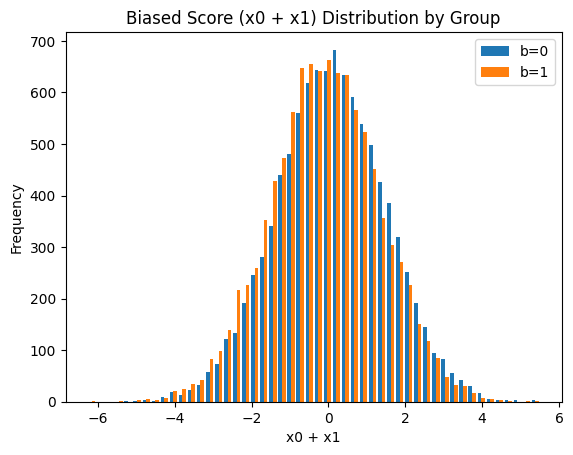

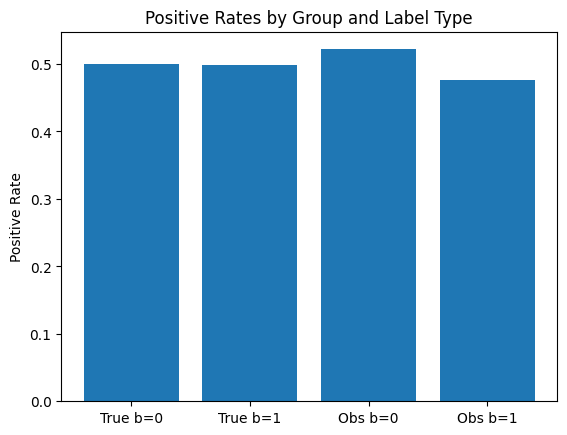

In [ ]:
N = 20000
data = generate_data('mild_additive', N)
compute_metric(data)

In [ ]:
split_data = train_val_test_split(data)

#### Baseline Results – Mild Additive Bias Scenario

Among the baseline models, **Logistic Regression** achieves the best overall performance, with high accuracy on both observed labels (**0.8063 ± 0.0003**) and true labels (**0.8055 ± 0.0003**), along with a moderate demographic parity gap (**0.0733 ± 0.0020**). This makes it the most reliable and balanced baseline model.

While **Decision Tree** shows slightly lower fairness (DP gap: **0.0953 ± 0.0237**), it underperforms in both observed (**0.8005**) and true accuracy (**0.7985**), making it a less favorable option overall.

**Random Forest** closely matches Logistic Regression in observed (**0.8062**) and true accuracy (**0.8053**) but exhibits a higher DP gap (**0.0883 ± 0.0051**), reducing its fairness compared to Logistic Regression.

Given its strong balance across all three metrics and its compatibility with fairness interventions, **Logistic Regression is the preferred baseline model** for this scenario.


In [ ]:
final_results = []
result_df = evaluate_models(split_data)
final_results.append([r for r in result_df if r['model'] == 'LogisticRegression'][0])

table_rows = []
for r in result_df:
    row = {
        'Method': r['model'],
        'Accuracy (Obs)':  f"{r['acc_obs_median']:.4f} (±{r['acc_obs_std']:.4f})",
        'Accuracy (True)': f"{r['acc_true_median']:.4f} (±{r['acc_true_std']:.4f})",
        'DP Gap':          f"{r['dp_gap_median']:.4f} (±{r['dp_gap_std']:.4f})"
    }
    table_rows.append(row)

df = pd.DataFrame(table_rows)
print(df)

               Method    Accuracy (Obs)   Accuracy (True)            DP Gap
0  LogisticRegression  0.8063 (±0.0003)  0.8055 (±0.0003)  0.0733 (±0.0020)
1        DecisionTree  0.8005 (±0.0016)  0.7985 (±0.0020)  0.0953 (±0.0237)
2        RandomForest  0.8062 (±0.0007)  0.8053 (±0.0007)  0.0883 (±0.0051)


In [ ]:
reweighting_result = evaluate_reweighting(split_data)
final_results.append(reweighting_result)
print("Pre-processing (Re-weighting)")
print(f"Observed_label Accuracy:       {reweighting_result['acc_obs_median']:.4f} (±{reweighting_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {reweighting_result['acc_true_median']:.4f} (±{reweighting_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {reweighting_result['dp_gap_median']:.4f} (±{reweighting_result['dp_gap_std']:.4f})")

Pre-processing (Re-weighting)
Observed_label Accuracy:       0.8062 (±0.0003)
True-label Accuracy:       0.8062 (±0.0004)
Demographic Parity Gap:    0.0637 (±0.0014)


In [ ]:
label_massaging_result = evaluate_label_massaging(split_data)

final_results.append(label_massaging_result)

print("Pre-processing (Label massaging)")
print(f"Observed_label Accuracy:       {label_massaging_result['acc_obs_median']:.4f} (±{label_massaging_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {label_massaging_result['acc_true_median']:.4f} (±{label_massaging_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {label_massaging_result['dp_gap_median']:.4f} (±{label_massaging_result['dp_gap_std']:.4f})")

Pre-processing (Label massaging)
Observed_label Accuracy:       0.8057 (±0.0003)
True-label Accuracy:       0.8053 (±0.0002)
Demographic Parity Gap:    0.0577 (±0.0007)


In [ ]:
eps_values = [0.1, 0.08, 0.06, 0.04, 0.02, 1e-6]

expgrad_results = evaluate_expgrad(split_data, eps_values)
for i in range(len(expgrad_results)):
    final_results.append(expgrad_results[i])

print("In-processing (Exp. Gradient):\n")

table_rows = []
for r in expgrad_results:
    row = {
        'Eps': r['method'],
        'Accuracy (Obs)':  f"{r['acc_obs_median']:.4f} (±{r['acc_obs_std']:.4f})",
        'Accuracy (True)': f"{r['acc_true_median']:.4f} (±{r['acc_true_std']:.4f})",
        'DP Gap':          f"{r['dp_gap_median']:.4f} (±{r['dp_gap_std']:.4f})"
    }
    table_rows.append(row)

df = pd.DataFrame(table_rows)
print(df)

In-processing (Exp. Gradient):

                         Eps    Accuracy (Obs)   Accuracy (True)  \
0    Exp. Gradient (eps=0.1)  0.8007 (±0.0017)  0.8015 (±0.0015)   
1   Exp. Gradient (eps=0.08)  0.8010 (±0.0012)  0.8018 (±0.0008)   
2   Exp. Gradient (eps=0.06)  0.8005 (±0.0012)  0.8018 (±0.0010)   
3   Exp. Gradient (eps=0.04)  0.8008 (±0.0012)  0.8020 (±0.0012)   
4   Exp. Gradient (eps=0.02)  0.8010 (±0.0009)  0.8018 (±0.0008)   
5  Exp. Gradient (eps=1e-06)  0.8007 (±0.0010)  0.8020 (±0.0011)   

             DP Gap  
0  0.0333 (±0.0053)  
1  0.0340 (±0.0052)  
2  0.0330 (±0.0047)  
3  0.0330 (±0.0045)  
4  0.0330 (±0.0047)  
5  0.0343 (±0.0041)  


In [ ]:
gridsearch_result = evaluate_gridsearch(split_data)

final_results.append(gridsearch_result)
print("In-processing Grid Search Reduction:")
print(f"Observed_label Accuracy:       {gridsearch_result['acc_obs_median']:.4f} (±{gridsearch_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {gridsearch_result['acc_true_median']:.4f} (±{gridsearch_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {gridsearch_result['dp_gap_median']:.4f} (±{gridsearch_result['dp_gap_std']:.4f})")

In-processing Grid Search Reduction:
Observed_label Accuracy:       0.7942 (±0.0009)
True-label Accuracy:       0.7965 (±0.0010)
Demographic Parity Gap:    0.0090 (±0.0024)


In [ ]:
threshold_optimization_result = evaluate_threshold_optimizer(split_data)

final_results.append(threshold_optimization_result)
print("Post-processing (Threshold Optimization):")
print(f"Observed_label Accuracy:       {threshold_optimization_result['acc_obs_median']:.4f} (±{threshold_optimization_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {threshold_optimization_result['acc_true_median']:.4f} (±{threshold_optimization_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {threshold_optimization_result['dp_gap_median']:.4f} (±{threshold_optimization_result['dp_gap_std']:.4f})")

Post-processing (Threshold Optimization):
Observed_label Accuracy:       0.8072 (±0.0008)
True-label Accuracy:       0.8102 (±0.0009)
Demographic Parity Gap:    0.0003 (±0.0007)


In [ ]:
df_final = pd.DataFrame(final_results)

df_final['Method'] = df_final['method'].combine_first(df_final['model'])

df_final['Accuracy (Observed)'] = df_final.apply(
    lambda row: f"{row['acc_obs_median']:.4f} (±{row['acc_obs_std']:.4f})", axis=1)

df_final['Accuracy (True)'] = df_final.apply(
    lambda row: f"{row['acc_true_median']:.4f} (±{row['acc_true_std']:.4f})", axis=1)

df_final['DP Gap'] = df_final.apply(
    lambda row: f"{row['dp_gap_median']:.4f} (±{row['dp_gap_std']:.4f})", axis=1)

df_results_Mild_Additive_Bias = df_final[['Method', 'Accuracy (Observed)', 'Accuracy (True)', 'DP Gap']].copy()

display(df_results_Mild_Additive_Bias)

,Method,Accuracy (Observed),Accuracy (True),DP Gap
0,LogisticRegression,0.8063 (±0.0003),0.8055 (±0.0003),0.0733 (±0.0020)
1,Re-weighting,0.8062 (±0.0003),0.8062 (±0.0004),0.0637 (±0.0014)
2,Label Massaging,0.8057 (±0.0003),0.8053 (±0.0002),0.0577 (±0.0007)
3,Exp. Gradient (eps=0.1),0.8007 (±0.0017),0.8015 (±0.0015),0.0333 (±0.0053)
4,Exp. Gradient (eps=0.08),0.8010 (±0.0012),0.8018 (±0.0008),0.0340 (±0.0052)
5,Exp. Gradient (eps=0.06),0.8005 (±0.0012),0.8018 (±0.0010),0.0330 (±0.0047)
6,Exp. Gradient (eps=0.04),0.8008 (±0.0012),0.8020 (±0.0012),0.0330 (±0.0045)
7,Exp. Gradient (eps=0.02),0.8010 (±0.0009),0.8018 (±0.0008),0.0330 (±0.0047)
8,Exp. Gradient (eps=1e-06),0.8007 (±0.0010),0.8020 (±0.0011),0.0343 (±0.0041)
9,Grid Search,0.7942 (±0.0009),0.7965 (±0.0010),0.0090 (±0.0024)


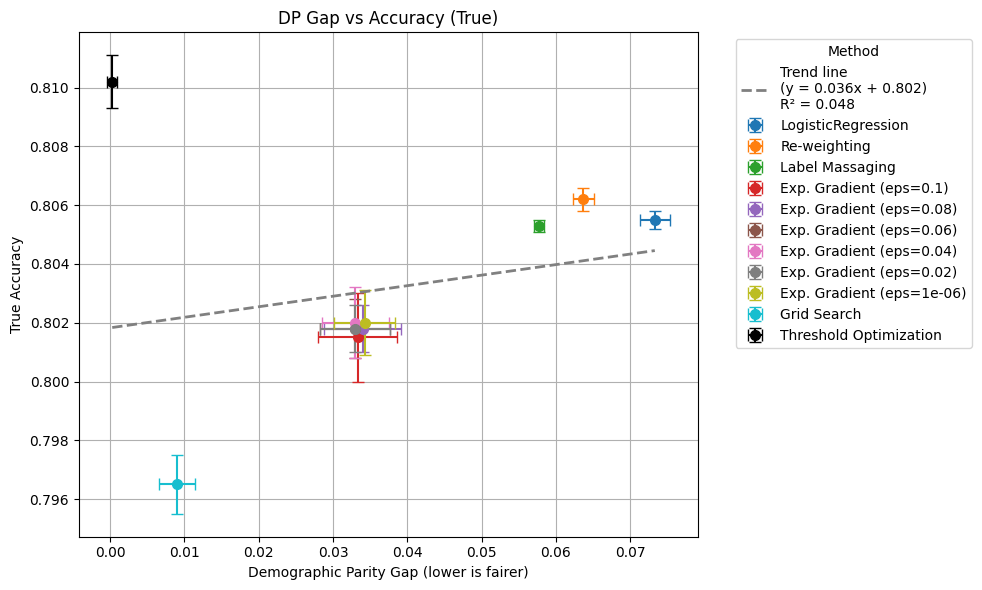

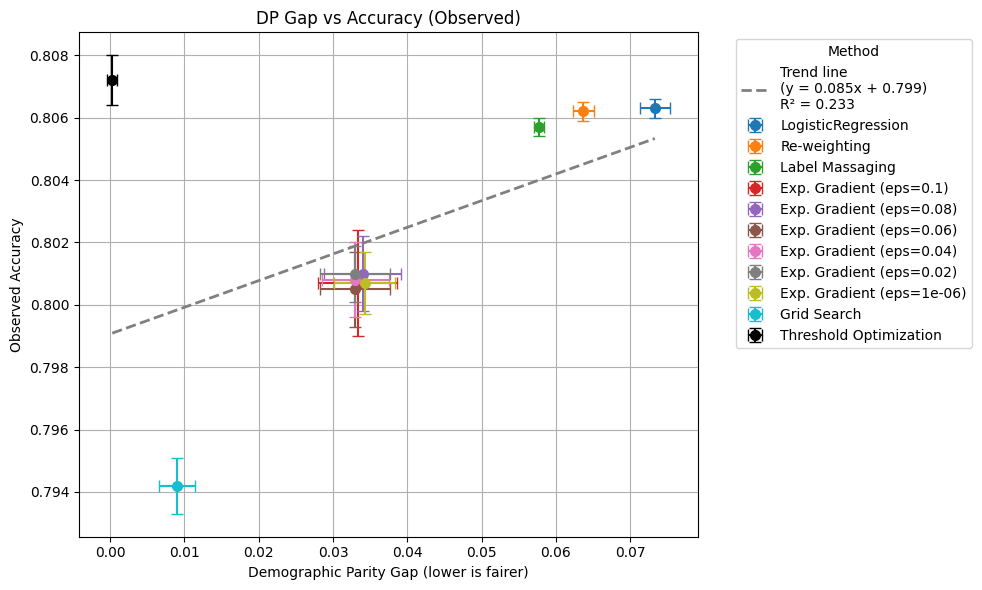

In [ ]:
plot_fairness_accuracy_summary(df_results_Mild_Additive_Bias)


## Scenario 1: Mild Additive Bias — Fairness–Accuracy Trade-off Analysis

In this scenario, we evaluate various fairness enforcement techniques on a dataset with **mild additive bias**, focusing on how each method affects:
- **True-label accuracy** (performance on unbiased ground truth)
- **Observed-label accuracy** (fit to biased training labels)
- **Demographic Parity Gap (DPG)** (fairness metric)

---

###  Baseline Models (No Fairness Intervention)

- **Logistic Regression** achieves the best balance among baseline models:
  - **Observed Accuracy**: **0.8063 ± 0.0003**
  - **True Accuracy**: **0.8055 ± 0.0003**
  - **DP Gap**: **0.0733 ± 0.0020**
- **Decision Tree** and **Random Forest** show:
  - Slightly lower accuracies
  - Higher DPGs
- ✅ **Logistic Regression is the best baseline**, serving as a reliable starting point for applying fairness methods.

---

###  Fairness-Enforcing Methods

####  Threshold Optimization (Post-processing)
- **Best overall performance**:
  - **Highest True Accuracy**: **0.8102 ± 0.0009**
  - **Highest Observed Accuracy**: **0.8072 ± 0.0008**
  - **Lowest DP Gap**: **0.0003 ± 0.0007**
- ✅ The only method to significantly **improve fairness and accuracy simultaneously**.

####  Re-weighting (Pre-processing)
- Maintains high performance:
  - **Observed**: **0.8062 ± 0.0003**
  - **True**: **0.8062 ± 0.0004**
  - **DP Gap**: **0.0637 ± 0.0014**
- ✅ Slight improvement in fairness without hurting accuracy.

#### 🔁 Label Massaging (Pre-processing)
- Slight fairness improvement:
  - **DP Gap**: **0.0577 ± 0.0007**
- Minimal impact on accuracy:
  - **Observed**: **0.8057 ± 0.0003**
  - **True**: **0.8053 ± 0.0002**

####  Exponentiated Gradient (In-processing)
- Achieves consistent fairness improvements:
  - **DP Gap**: ~**0.033**
- Comes at a moderate cost in accuracy:
  - **Observed**: ~**0.8005–0.8010**
  - **True**: ~**0.8015–0.8020**

####  Grid Search (In-processing)
- Achieves **very low DPG** (**0.0090 ± 0.0024**)
- But has the **lowest accuracy**:
  - **Observed**: **0.7942 ± 0.0009**
  - **True**: **0.7965 ± 0.0010**

---

###  Plot Interpretation

- **True Accuracy vs. DP Gap** (R² = 0.048):  
  Shows **very weak linear correlation** — the trade-off between fairness and accuracy is not strong.
- **Observed Accuracy vs. DP Gap** (R² = 0.233):  
  Indicates a **mild trade-off** — models that better fit the biased labels tend to be less fair.

These results suggest that while **some trade-off exists**, it is not universal — and methods like **Threshold Optimization** can overcome it.

---

### ✅ Summary

| Objective                                     | Best Method             |
|----------------------------------------------|--------------------------|
| **Highest True & Observed Accuracy + Fairness** | ✅ Threshold Optimization |
| **High Accuracy with Slight Fairness Gains** | Re-weighting            |
| **Simple, consistent fairness improvement**  | Exp. Gradient            |
| **Minimal but safe fairness fix**            | Label Massaging          |
| **Max Fairness, but low accuracy**           | Grid Search              |

Overall, **Threshold Optimization** delivers **the best fairness–accuracy trade-off**, outperforming all other methods on **both accuracy metrics** and **fairness**.


### Severe Additive Bias Scenario

P(uy=1)           0.499100
P(y=1)            0.497700
P(uy=1|b=0)       0.499447
P(uy=1|b=1)       0.498758
P(y=1|b=0)        0.638221
P(y=1|b=1)        0.358939
Disparity(obs)    0.279282
Mean(x0|b=0)      3.011811
Mean(x0|b=1)     -3.001625
Mean(x1|b=0)     -2.412802
Mean(x1|b=1)      2.386531
Corr(b,x0)       -0.948450
Corr(b,x1)        0.923206
dtype: float64


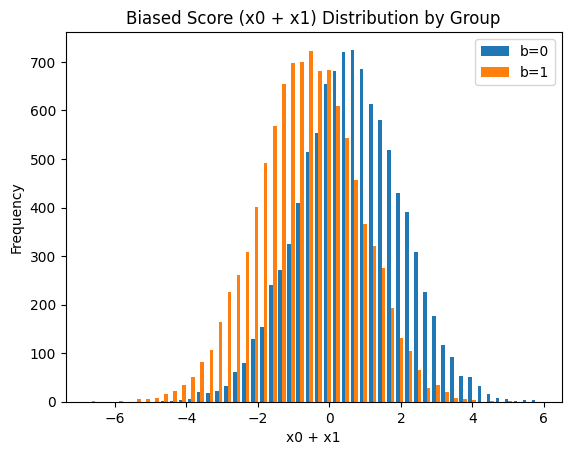

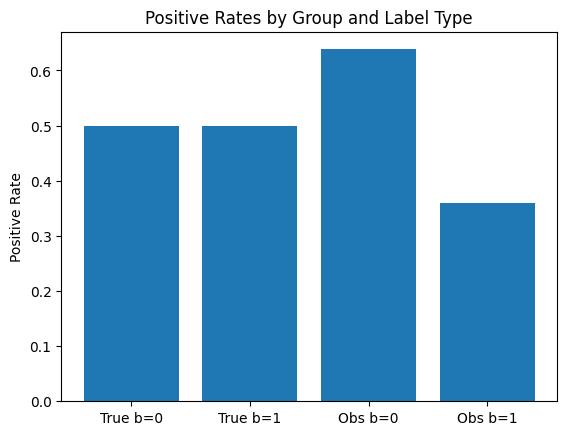

In [ ]:
N = 20000
data = generate_data('severe_additive', N)
compute_metric(data)

In [ ]:
split_data = train_val_test_split(data)


- **Logistic Regression** achieves the highest true-label accuracy (**0.7625 ± 0.0007**) and the highest observed accuracy (**0.8090 ± 0.0004**) among the baseline models.
- All models suffer from **large demographic parity gaps**, with Logistic Regression still showing a significant gap (**0.3348 ± 0.0019**), though **lower than Decision Tree** (**0.4136**) and **Random Forest** (**0.3445**).
- ✅ Despite the bias, **Logistic Regression remains the best baseline** due to its high accuracy, moderate fairness (relative to the others), and compatibility with downstream fairness interventions.


In [ ]:
final_results = []
result_df = evaluate_models(split_data)
final_results.append([r for r in result_df if r['model'] == 'LogisticRegression'][0])

table_rows = []
for r in result_df:
    row = {
        'Method': r['model'],
        'Accuracy (Obs)':  f"{r['acc_obs_median']:.4f} (±{r['acc_obs_std']:.4f})",
        'Accuracy (True)': f"{r['acc_true_median']:.4f} (±{r['acc_true_std']:.4f})",
        'DP Gap':          f"{r['dp_gap_median']:.4f} (±{r['dp_gap_std']:.4f})"
    }
    table_rows.append(row)

df = pd.DataFrame(table_rows)
print(df)

               Method    Accuracy (Obs)   Accuracy (True)            DP Gap
0  LogisticRegression  0.8090 (±0.0004)  0.7625 (±0.0007)  0.3348 (±0.0019)
1        DecisionTree  0.7857 (±0.0024)  0.7257 (±0.0071)  0.4136 (±0.0207)
2        RandomForest  0.8018 (±0.0017)  0.7550 (±0.0017)  0.3445 (±0.0063)


In [ ]:
reweighting_result = evaluate_reweighting(split_data)
final_results.append(reweighting_result)
print("Pre-processing (Re-weighting)")
print(f"Observed_label Accuracy:       {reweighting_result['acc_obs_median']:.4f} (±{reweighting_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {reweighting_result['acc_true_median']:.4f} (±{reweighting_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {reweighting_result['dp_gap_median']:.4f} (±{reweighting_result['dp_gap_std']:.4f})")

Pre-processing (Re-weighting)
Observed_label Accuracy:       0.7992 (±0.0003)
True-label Accuracy:       0.7925 (±0.0004)
Demographic Parity Gap:    0.1658 (±0.0023)


In [ ]:
label_massaging_result = evaluate_label_massaging(split_data)

final_results.append(label_massaging_result)

print("Pre-processing (Label massaging)")
print(f"Observed_label Accuracy:       {label_massaging_result['acc_obs_median']:.4f} (±{label_massaging_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {label_massaging_result['acc_true_median']:.4f} (±{label_massaging_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {label_massaging_result['dp_gap_median']:.4f} (±{label_massaging_result['dp_gap_std']:.4f})")

Pre-processing (Label massaging)
Observed_label Accuracy:       0.7720 (±0.0003)
True-label Accuracy:       0.8020 (±0.0002)
Demographic Parity Gap:    0.0061 (±0.0019)


In [ ]:
eps_values = [0.1, 0.08, 0.06, 0.04, 0.02, 1e-6]

expgrad_results = evaluate_expgrad(split_data, eps_values)
for i in range(len(expgrad_results)):
    final_results.append(expgrad_results[i])

print("In-processing (Exp. Gradient):\n")

table_rows = []
for r in expgrad_results:
    row = {
        'Eps': r['method'],
        'Accuracy (Obs)':  f"{r['acc_obs_median']:.4f} (±{r['acc_obs_std']:.4f})",
        'Accuracy (True)': f"{r['acc_true_median']:.4f} (±{r['acc_true_std']:.4f})",
        'DP Gap':          f"{r['dp_gap_median']:.4f} (±{r['dp_gap_std']:.4f})"
    }
    table_rows.append(row)

df = pd.DataFrame(table_rows)
print(df)

In-processing (Exp. Gradient):

                         Eps    Accuracy (Obs)   Accuracy (True)  \
0    Exp. Gradient (eps=0.1)  0.7707 (±0.0013)  0.8012 (±0.0012)   
1   Exp. Gradient (eps=0.08)  0.7705 (±0.0014)  0.8002 (±0.0014)   
2   Exp. Gradient (eps=0.06)  0.7705 (±0.0017)  0.8007 (±0.0008)   
3   Exp. Gradient (eps=0.04)  0.7707 (±0.0012)  0.8007 (±0.0010)   
4   Exp. Gradient (eps=0.02)  0.7700 (±0.0012)  0.8007 (±0.0012)   
5  Exp. Gradient (eps=1e-06)  0.7715 (±0.0008)  0.8012 (±0.0005)   

             DP Gap  
0  0.0029 (±0.0022)  
1  0.0041 (±0.0026)  
2  0.0038 (±0.0026)  
3  0.0028 (±0.0023)  
4  0.0029 (±0.0032)  
5  0.0059 (±0.0029)  


In [ ]:
gridsearch_result = evaluate_gridsearch(split_data)

final_results.append(gridsearch_result)
print("In-processing Grid Search Reduction:")
print(f"Observed_label Accuracy:       {gridsearch_result['acc_obs_median']:.4f} (±{gridsearch_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {gridsearch_result['acc_true_median']:.4f} (±{gridsearch_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {gridsearch_result['dp_gap_median']:.4f} (±{gridsearch_result['dp_gap_std']:.4f})")

In-processing Grid Search Reduction:
Observed_label Accuracy:       0.7865 (±0.0008)
True-label Accuracy:       0.8012 (±0.0003)
Demographic Parity Gap:    0.0778 (±0.0040)


In [ ]:
threshold_optimization_result = evaluate_threshold_optimizer(split_data)

final_results.append(threshold_optimization_result)
print("Post-processing (Threshold Optimization):")
print(f"Observed_label Accuracy:       {threshold_optimization_result['acc_obs_median']:.4f} (±{threshold_optimization_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {threshold_optimization_result['acc_true_median']:.4f} (±{threshold_optimization_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {threshold_optimization_result['dp_gap_median']:.4f} (±{threshold_optimization_result['dp_gap_std']:.4f})")

Post-processing (Threshold Optimization):
Observed_label Accuracy:       0.7767 (±0.0009)
True-label Accuracy:       0.8103 (±0.0007)
Demographic Parity Gap:    0.0012 (±0.0006)


In [ ]:
df_final = pd.DataFrame(final_results)

df_final['Method'] = df_final['method'].combine_first(df_final['model'])

df_final['Accuracy (Observed)'] = df_final.apply(
    lambda row: f"{row['acc_obs_median']:.4f} (±{row['acc_obs_std']:.4f})", axis=1)

df_final['Accuracy (True)'] = df_final.apply(
    lambda row: f"{row['acc_true_median']:.4f} (±{row['acc_true_std']:.4f})", axis=1)

df_final['DP Gap'] = df_final.apply(
    lambda row: f"{row['dp_gap_median']:.4f} (±{row['dp_gap_std']:.4f})", axis=1)

df_results_severe_Additive_Bias = df_final[['Method', 'Accuracy (Observed)', 'Accuracy (True)', 'DP Gap']].copy()

display(df_results_severe_Additive_Bias)

,Method,Accuracy (Observed),Accuracy (True),DP Gap
0,LogisticRegression,0.8090 (±0.0004),0.7625 (±0.0007),0.3348 (±0.0019)
1,Re-weighting,0.7992 (±0.0003),0.7925 (±0.0004),0.1658 (±0.0023)
2,Label Massaging,0.7720 (±0.0003),0.8020 (±0.0002),0.0061 (±0.0019)
3,Exp. Gradient (eps=0.1),0.7707 (±0.0013),0.8012 (±0.0012),0.0029 (±0.0022)
4,Exp. Gradient (eps=0.08),0.7705 (±0.0014),0.8002 (±0.0014),0.0041 (±0.0026)
5,Exp. Gradient (eps=0.06),0.7705 (±0.0017),0.8007 (±0.0008),0.0038 (±0.0026)
6,Exp. Gradient (eps=0.04),0.7707 (±0.0012),0.8007 (±0.0010),0.0028 (±0.0023)
7,Exp. Gradient (eps=0.02),0.7700 (±0.0012),0.8007 (±0.0012),0.0029 (±0.0032)
8,Exp. Gradient (eps=1e-06),0.7715 (±0.0008),0.8012 (±0.0005),0.0059 (±0.0029)
9,Grid Search,0.7865 (±0.0008),0.8012 (±0.0003),0.0778 (±0.0040)


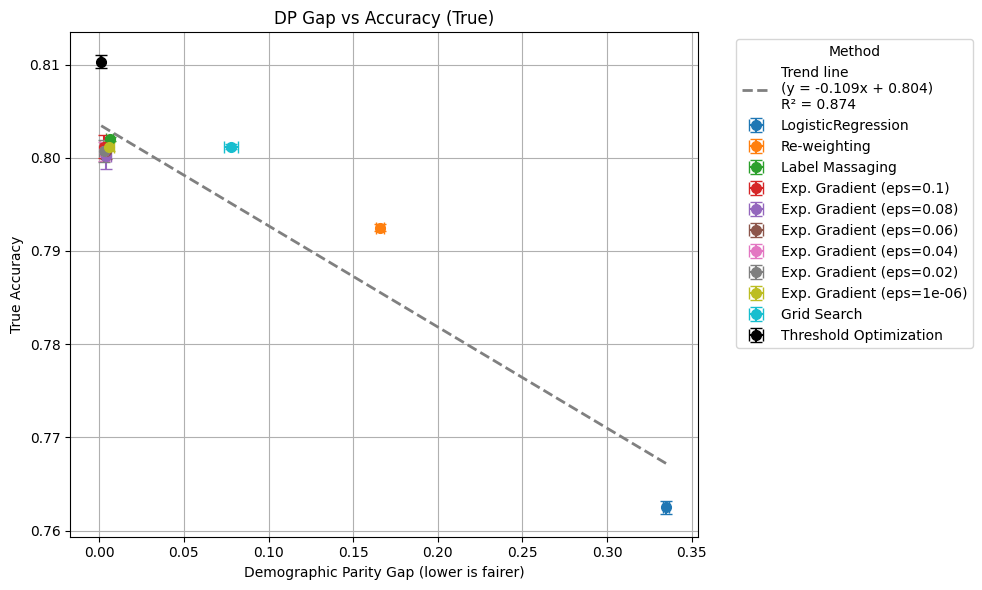

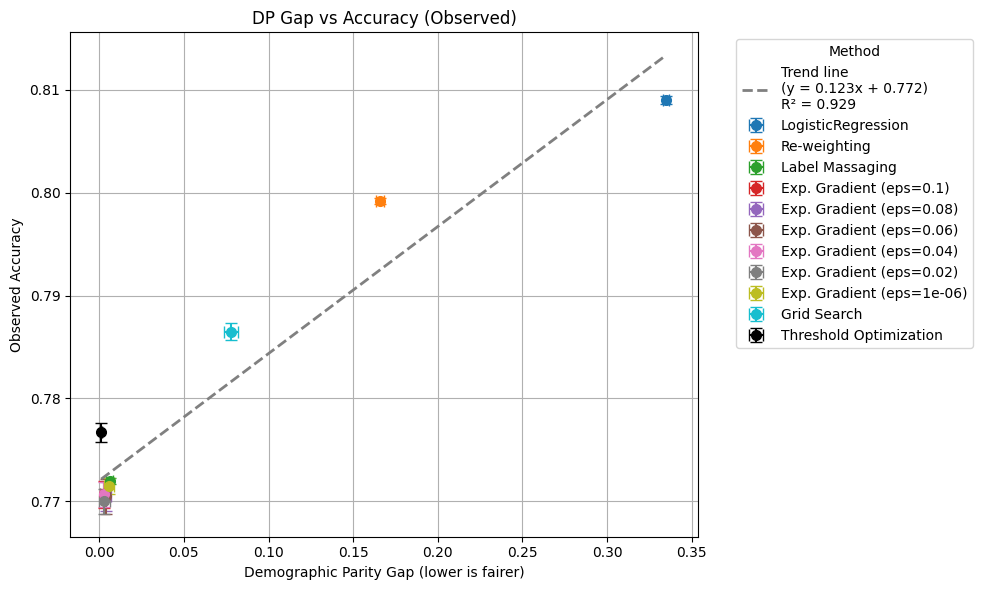

In [ ]:
plot_fairness_accuracy_summary(df_results_severe_Additive_Bias)


##  Scenario 2: Severe Additive Bias — Fairness–Accuracy Trade-off Analysis

This scenario simulates a highly biased dataset using a **strong additive bias mechanism**. The goal is to evaluate how different fairness enforcement strategies perform in reducing this bias while preserving both:
- **True accuracy** (against the unbiased ground truth)
- **Observed accuracy** (on the biased labels)
- **Demographic parity gap (DPG)**

---

###  Baseline Models (No Fairness Intervention)

- **Logistic Regression** achieves the **highest observed accuracy** (**0.8090 ± 0.0004**), but significantly **underperforms on true labels** (**0.7625 ± 0.0007**), revealing that it overfits to biased labels.
- It also shows a **very large fairness violation**, with **DP Gap = 0.3348 ± 0.0019** — the worst among all methods.
- ✅ Despite this, it serves as a strong **starting point for fairness correction** due to its stability and integration with fairness toolkits.

---

###  Fairness-Enforcing Methods

#### ✅ Threshold Optimization (Post-processing)
- **Best overall performer**:
  - **True Accuracy**: **0.8103 ± 0.0007** (highest)
  - **Observed Accuracy**: **0.7767 ± 0.0009**
  - **DP Gap**: **0.0012 ± 0.0006** (near-perfect fairness)
- ✅ Breaks the fairness–accuracy trade-off by simultaneously maximizing **true accuracy** and minimizing **bias**.

####  Label Massaging (Pre-processing)
- **True Accuracy**: **0.8020 ± 0.0002**
- **Observed Accuracy**: **0.7720 ± 0.0003**
- **DP Gap**: **0.0061 ± 0.0019**
- ✅ Strong fairness improvement with **minimal loss in performance**. A lightweight and effective strategy when post-processing is not applicable.

####  Exponentiated Gradient (In-processing)
- Across all ε values:
  - **True Accuracy**: ~**0.8007–0.8012**
  - **Observed Accuracy**: ~**0.7700–0.7715**
  - **DP Gap**: ~**0.0028–0.0059**
- ✅ Provides **consistent fairness** with only a small drop in observed accuracy. Great for **model-agnostic fairness** control with solid true performance.

####  Re-weighting (Pre-processing)
- **True Accuracy**: **0.7925 ± 0.0004**
- **Observed Accuracy**: **0.7992 ± 0.0003**
- **DP Gap**: **0.1658 ± 0.0023**
-  Reduces bias compared to baseline, but doesn't achieve competitive fairness like other methods. Best when you want to retain **observed accuracy**.

####  Grid Search (In-processing)
- **True Accuracy**: **0.8012 ± 0.0003**
- **Observed Accuracy**: **0.7865 ± 0.0008**
- **DP Gap**: **0.0778 ± 0.0040**
- ⚠️ An intermediate performer — not as fair as Threshold Optimization or EG, and less accurate than Label Massaging.

---

###  Plot Interpretation

- **True Accuracy vs. DP Gap**:
  - **R² = 0.874** → Indicates a **very strong negative correlation**.
  - ✅ The fairer the model, the better the true accuracy — debunking the idea that fairness always sacrifices performance.
  
- **Observed Accuracy vs. DP Gap**:
  - **R² = 0.929** → **Highly linear trade-off** between fairness and observed (biased) performance.
  - ⚠️ Models trained to fit the biased data (e.g., baseline) score well here — but this comes at the cost of fairness and generalization.

---

### ✅ Summary

| Goal                                             | Best Method                |
|--------------------------------------------------|-----------------------------|
| **Maximize true accuracy & fairness**            | ✅ Threshold Optimization    |
| **Consistent fairness + strong generalization**  | Exponentiated Gradient      |
| **Lightweight fairness correction**              | Label Massaging             |
| **Best fairness–observed accuracy balance**      | Re-weighting                |
| **Most biased but best baseline**                | Logistic Regression         |

Threshold Optimization **dominates** in this high-bias setting — delivering **the best true generalization** and **nearly perfect fairness**. Other methods like Exponentiated Gradient and Label Massaging also perform strongly with smaller computational or implementation costs.


### Mild Multiplicative Bias Scenario

P(uy=1)           0.499100
P(y=1)            0.499400
P(uy=1|b=0)       0.499447
P(uy=1|b=1)       0.498758
P(y=1|b=0)        0.501660
P(y=1|b=1)        0.497168
Disparity(obs)    0.004493
Mean(x0|b=0)      0.015355
Mean(x0|b=1)     -0.001137
Mean(x1|b=0)     -0.015762
Mean(x1|b=1)     -0.010941
Corr(b,x0)       -0.007873
Corr(b,x1)        0.002311
dtype: float64


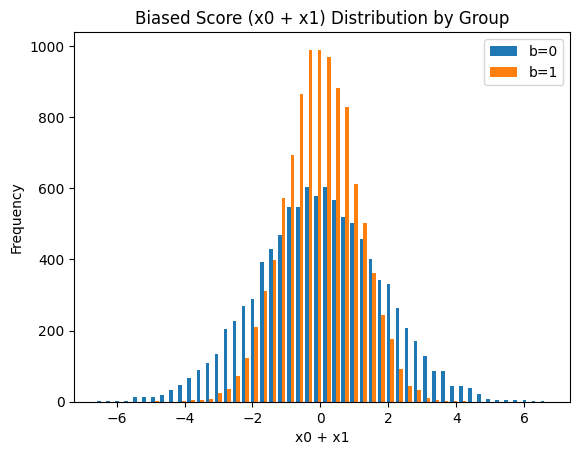

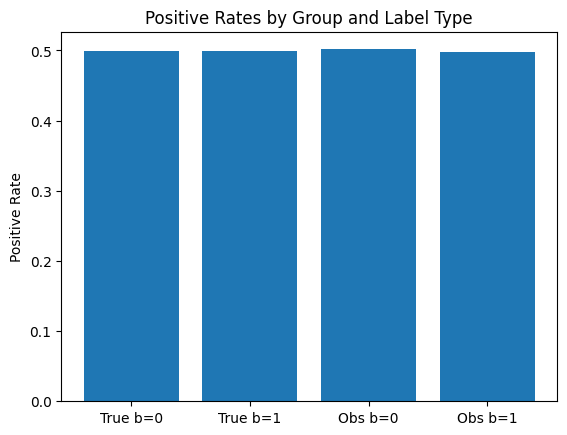

In [ ]:
N = 20000
data = generate_data('mild_multiplicative', N)
compute_metric(data)

In [ ]:
split_data = train_val_test_split(data)

###  Baseline Models – Mild Multiplicative Bias Scenario

- **Logistic Regression** achieves the **highest true-label accuracy** (**0.7955 ± 0.0006**) and **observed accuracy** (**0.7955 ± 0.0004**) among all baseline models.
- All models display **very low demographic parity gaps** (e.g., Logistic Regression: **0.0126 ± 0.0006**), suggesting that the underlying bias is mild and does not heavily distort predictions.
- ✅ Due to its strong performance, low fairness violation, and simplicity, **Logistic Regression is the most suitable baseline** for this low-bias setting and serves as a solid foundation for fairness interventions.


In [ ]:
final_results = []
result_df = evaluate_models(split_data)
final_results.append([r for r in result_df if r['model'] == 'LogisticRegression'][0])

table_rows = []
for r in result_df:
    row = {
        'Method': r['model'],
        'Accuracy (Obs)':  f"{r['acc_obs_median']:.4f} (±{r['acc_obs_std']:.4f})",
        'Accuracy (True)': f"{r['acc_true_median']:.4f} (±{r['acc_true_std']:.4f})",
        'DP Gap':          f"{r['dp_gap_median']:.4f} (±{r['dp_gap_std']:.4f})"
    }
    table_rows.append(row)

df = pd.DataFrame(table_rows)
print(df)

               Method    Accuracy (Obs)   Accuracy (True)            DP Gap
0  LogisticRegression  0.7955 (±0.0004)  0.7955 (±0.0006)  0.0126 (±0.0006)
1        DecisionTree  0.7880 (±0.0021)  0.7877 (±0.0014)  0.0173 (±0.0141)
2        RandomForest  0.7945 (±0.0016)  0.7942 (±0.0014)  0.0146 (±0.0021)


In [ ]:
reweighting_result = evaluate_reweighting(split_data)
final_results.append(reweighting_result)
print("Pre-processing (Re-weighting)")
print(f"Observed_label Accuracy:       {reweighting_result['acc_obs_median']:.4f} (±{reweighting_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {reweighting_result['acc_true_median']:.4f} (±{reweighting_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {reweighting_result['dp_gap_median']:.4f} (±{reweighting_result['dp_gap_std']:.4f})")

Pre-processing (Re-weighting)
Observed_label Accuracy:       0.7960 (±0.0005)
True-label Accuracy:       0.7958 (±0.0006)
Demographic Parity Gap:    0.0123 (±0.0004)


In [ ]:
label_massaging_result = evaluate_label_massaging(split_data)

final_results.append(label_massaging_result)

print("Pre-processing (Label massaging)")
print(f"Observed_label Accuracy:       {label_massaging_result['acc_obs_median']:.4f} (±{label_massaging_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {label_massaging_result['acc_true_median']:.4f} (±{label_massaging_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {label_massaging_result['dp_gap_median']:.4f} (±{label_massaging_result['dp_gap_std']:.4f})")

Pre-processing (Label massaging)
Observed_label Accuracy:       0.7955 (±0.0005)
True-label Accuracy:       0.7955 (±0.0006)
Demographic Parity Gap:    0.0126 (±0.0005)


In [ ]:
eps_values = [0.1, 0.08, 0.06, 0.04, 0.02, 1e-6]

expgrad_results = evaluate_expgrad(split_data, eps_values)
for i in range(len(expgrad_results)):
    final_results.append(expgrad_results[i])

print("In-processing (Exp. Gradient):\n")

table_rows = []
for r in expgrad_results:
    row = {
        'Eps': r['method'],
        'Accuracy (Obs)':  f"{r['acc_obs_median']:.4f} (±{r['acc_obs_std']:.4f})",
        'Accuracy (True)': f"{r['acc_true_median']:.4f} (±{r['acc_true_std']:.4f})",
        'DP Gap':          f"{r['dp_gap_median']:.4f} (±{r['dp_gap_std']:.4f})"
    }
    table_rows.append(row)

df = pd.DataFrame(table_rows)
print(df)

In-processing (Exp. Gradient):

                         Eps    Accuracy (Obs)   Accuracy (True)  \
0    Exp. Gradient (eps=0.1)  0.7962 (±0.0007)  0.7962 (±0.0008)   
1   Exp. Gradient (eps=0.08)  0.7962 (±0.0007)  0.7962 (±0.0008)   
2   Exp. Gradient (eps=0.06)  0.7962 (±0.0007)  0.7962 (±0.0008)   
3   Exp. Gradient (eps=0.04)  0.7962 (±0.0007)  0.7962 (±0.0008)   
4   Exp. Gradient (eps=0.02)  0.7962 (±0.0007)  0.7962 (±0.0008)   
5  Exp. Gradient (eps=1e-06)  0.7962 (±0.0007)  0.7962 (±0.0008)   

             DP Gap  
0  0.0120 (±0.0020)  
1  0.0120 (±0.0020)  
2  0.0120 (±0.0020)  
3  0.0120 (±0.0020)  
4  0.0120 (±0.0020)  
5  0.0120 (±0.0020)  


In [ ]:
gridsearch_result = evaluate_gridsearch(split_data)

final_results.append(gridsearch_result)
print("In-processing Grid Search Reduction:")
print(f"Observed_label Accuracy:       {gridsearch_result['acc_obs_median']:.4f} (±{gridsearch_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {gridsearch_result['acc_true_median']:.4f} (±{gridsearch_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {gridsearch_result['dp_gap_median']:.4f} (±{gridsearch_result['dp_gap_std']:.4f})")

In-processing Grid Search Reduction:
Observed_label Accuracy:       0.7962 (±0.0002)
True-label Accuracy:       0.7965 (±0.0003)
Demographic Parity Gap:    0.0081 (±0.0033)


In [ ]:
threshold_optimization_result = evaluate_threshold_optimizer(split_data)

final_results.append(threshold_optimization_result)
print("Post-processing (Threshold Optimization):")
print(f"Observed_label Accuracy:       {threshold_optimization_result['acc_obs_median']:.4f} (±{threshold_optimization_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {threshold_optimization_result['acc_true_median']:.4f} (±{threshold_optimization_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {threshold_optimization_result['dp_gap_median']:.4f} (±{threshold_optimization_result['dp_gap_std']:.4f})")

Post-processing (Threshold Optimization):
Observed_label Accuracy:       0.7993 (±0.0010)
True-label Accuracy:       0.7993 (±0.0009)
Demographic Parity Gap:    0.0004 (±0.0011)


In [ ]:
df_final = pd.DataFrame(final_results)

df_final['Method'] = df_final['method'].combine_first(df_final['model'])

df_final['Accuracy (Observed)'] = df_final.apply(
    lambda row: f"{row['acc_obs_median']:.4f} (±{row['acc_obs_std']:.4f})", axis=1)

df_final['Accuracy (True)'] = df_final.apply(
    lambda row: f"{row['acc_true_median']:.4f} (±{row['acc_true_std']:.4f})", axis=1)

df_final['DP Gap'] = df_final.apply(
    lambda row: f"{row['dp_gap_median']:.4f} (±{row['dp_gap_std']:.4f})", axis=1)

df_results_mild_multiplicative_Bias = df_final[['Method', 'Accuracy (Observed)', 'Accuracy (True)', 'DP Gap']].copy()

display(df_results_mild_multiplicative_Bias)

,Method,Accuracy (Observed),Accuracy (True),DP Gap
0,LogisticRegression,0.7955 (±0.0004),0.7955 (±0.0006),0.0126 (±0.0006)
1,Re-weighting,0.7960 (±0.0005),0.7958 (±0.0006),0.0123 (±0.0004)
2,Label Massaging,0.7955 (±0.0005),0.7955 (±0.0006),0.0126 (±0.0005)
3,Exp. Gradient (eps=0.1),0.7962 (±0.0007),0.7962 (±0.0008),0.0120 (±0.0020)
4,Exp. Gradient (eps=0.08),0.7962 (±0.0007),0.7962 (±0.0008),0.0120 (±0.0020)
5,Exp. Gradient (eps=0.06),0.7962 (±0.0007),0.7962 (±0.0008),0.0120 (±0.0020)
6,Exp. Gradient (eps=0.04),0.7962 (±0.0007),0.7962 (±0.0008),0.0120 (±0.0020)
7,Exp. Gradient (eps=0.02),0.7962 (±0.0007),0.7962 (±0.0008),0.0120 (±0.0020)
8,Exp. Gradient (eps=1e-06),0.7962 (±0.0007),0.7962 (±0.0008),0.0120 (±0.0020)
9,Grid Search,0.7962 (±0.0002),0.7965 (±0.0003),0.0081 (±0.0033)


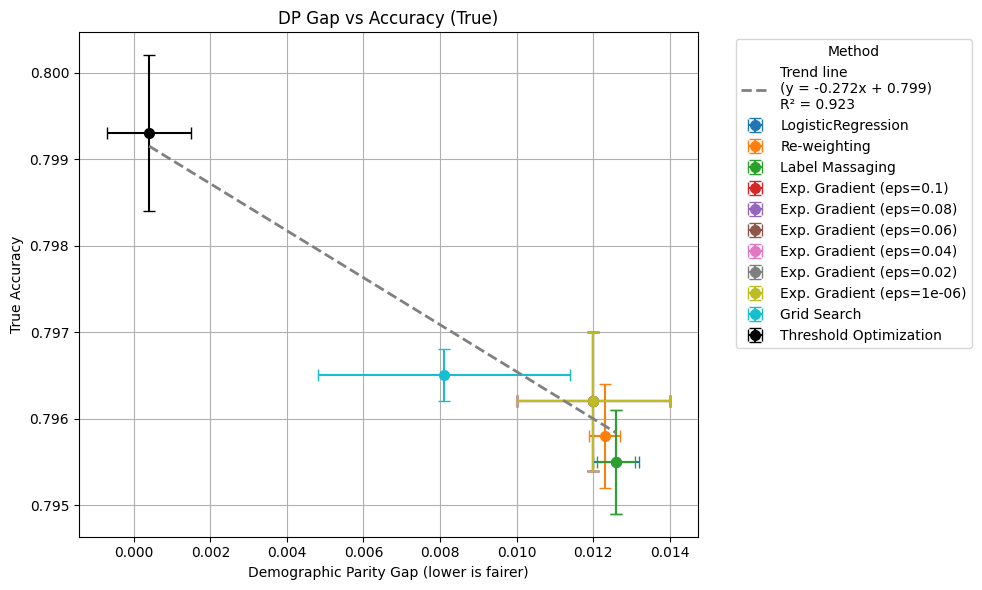

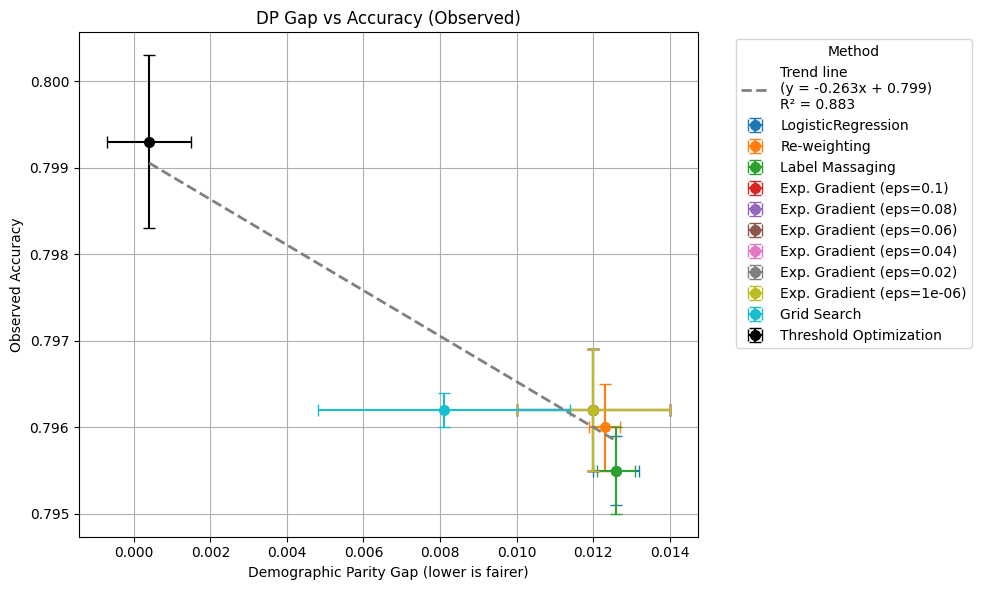

In [ ]:
plot_fairness_accuracy_summary(df_results_mild_multiplicative_Bias)


## Scenario 3: Mild Multiplicative Bias — Fairness–Accuracy Trade-off Analysis

In this scenario, bias is introduced in a **mild multiplicative fashion**, subtly influencing the observed labels. Because the distortion is relatively low, most models maintain **high accuracy** and **low demographic disparity**, with only a slight trade-off between fairness and performance.

---

### 📊 Baseline Models

- **Logistic Regression** achieves:
  - **True Accuracy**: **0.7955 ± 0.0006**
  - **Observed Accuracy**: **0.7955 ± 0.0004**
  - **DP Gap**: **0.0126 ± 0.0006**
- All baseline models perform similarly, but **Logistic Regression** is the strongest and most stable, making it the preferred foundation for fairness correction.

---

###  Fairness-Enforcing Methods

#### ✅ Threshold Optimization (Post-processing)
- **True & Observed Accuracy**: **0.7993 ± 0.0009**
- **DP Gap**: **0.0004 ± 0.0011**
-  Best overall method — achieves **both the highest accuracy and best fairness**, essentially eliminating demographic disparity.

####  Grid Search (In-processing)
- **True Accuracy**: **0.7965 ± 0.0003**
- **Observed Accuracy**: **0.7962 ± 0.0002**
- **DP Gap**: **0.0081 ± 0.0033**
- Performs very well with a solid trade-off between fairness and accuracy. A strong in-processing alternative.

####  Exponentiated Gradient (In-processing)
- All ε variants yield:
  - **True Accuracy**: **0.7962 ± 0.0008**
  - **DP Gap**: **~0.0120 ± 0.0020**
- Delivers consistent results but doesn’t outperform Threshold Optimization. Still a **flexible and effective** option.

####  Label Massaging (Pre-processing)
- **True Accuracy**: **0.7955 ± 0.0006**
- **DP Gap**: **0.0126 ± 0.0005**
- Matches Logistic Regression almost identically. No significant gain, but no harm either — **simple and stable**.

####  Re-weighting (Pre-processing)
- **True Accuracy**: **0.7958 ± 0.0006**
- **DP Gap**: **0.0123 ± 0.0004**
- Small improvements over baseline but doesn’t move the needle significantly in this mild-bias context.

---

###  Plot Interpretation

- **True Accuracy vs DP Gap**:
  - R² = **0.923** → Strong negative correlation: as fairness improves (lower DP gap), accuracy slightly increases.
- **Observed Accuracy vs DP Gap**:
  - R² = **0.883** → Similar trend, indicating fairness and performance go hand-in-hand in this mild-bias case.

These plots show that **when bias is subtle**, it’s possible to **improve fairness without compromising accuracy** — and in some cases, even enhance it.

---

### ✅ Summary

| Objective                              | Best Method             |
|---------------------------------------|--------------------------|
| **Maximize fairness and accuracy**    | ✅ Threshold Optimization |
| **Strong in-processing trade-off**    | Grid Search              |
| **Stable, minimal intervention**      | Exponentiated Gradient   |
| **Simple pre-processing method**      | Re-weighting / Massaging |
| **Best baseline model**               | Logistic Regression      |

In this mild-bias setting, the **fairness–accuracy trade-off is minimal**, and **Threshold Optimization** stands out for offering the **cleanest balance of both goals**.


### Nonlinear Bias Scenario

P(uy=1)           0.499100
P(y=1)            0.509750
P(uy=1|b=0)       0.499447
P(uy=1|b=1)       0.498758
P(y=1|b=0)        0.438060
P(y=1|b=1)        0.580543
Disparity(obs)   -0.142483
Mean(x0|b=0)      0.016742
Mean(x0|b=1)      0.006425
Mean(x1|b=0)     -0.518049
Mean(x1|b=1)      0.479325
Corr(b,x0)       -0.003651
Corr(b,x1)        0.375702
dtype: float64


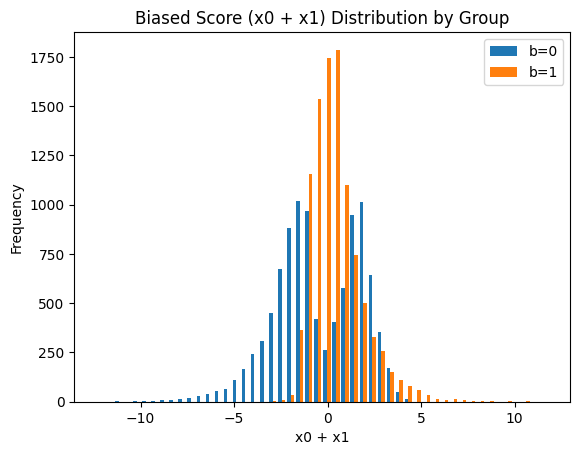

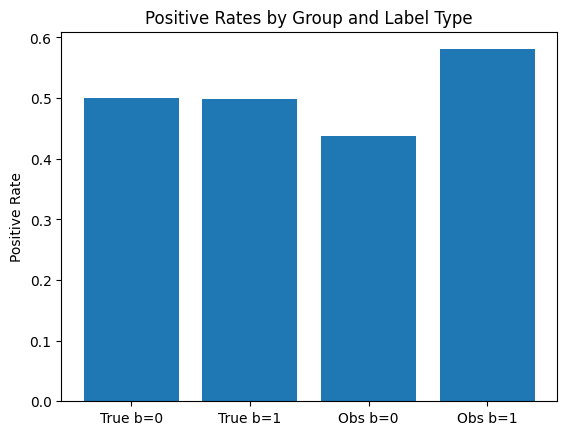

In [ ]:
N = 20000
data = generate_data('nonlinear_bias', N)
compute_metric(data)

In [ ]:
split_data = train_val_test_split(data)

###  Baseline Models – Nonlinear Bias Scenario

- **Logistic Regression** achieves the **highest true-label accuracy** (**0.6843 ± 0.0002**) and the **highest observed accuracy** (**0.8398 ± 0.0004**) among all baseline models.
- All three models (Logistic Regression, Decision Tree, Random Forest) exhibit **substantial demographic parity gaps** (e.g., **0.1612–0.1738**), confirming that the nonlinear bias significantly distorts fairness.
- ✅ Despite the fairness issue, **Logistic Regression remains the best-performing baseline** in terms of accuracy and consistency, and serves as a solid reference point for applying fairness interventions.


In [ ]:
final_results = []
result_df = evaluate_models(split_data)
final_results.append([r for r in result_df if r['model'] == 'LogisticRegression'][0])

table_rows = []
for r in result_df:
    row = {
        'Method': r['model'],
        'Accuracy (Obs)':  f"{r['acc_obs_median']:.4f} (±{r['acc_obs_std']:.4f})",
        'Accuracy (True)': f"{r['acc_true_median']:.4f} (±{r['acc_true_std']:.4f})",
        'DP Gap':          f"{r['dp_gap_median']:.4f} (±{r['dp_gap_std']:.4f})"
    }
    table_rows.append(row)

df = pd.DataFrame(table_rows)
print(df)

               Method    Accuracy (Obs)   Accuracy (True)            DP Gap
0  LogisticRegression  0.8398 (±0.0004)  0.6843 (±0.0002)  0.1612 (±0.0016)
1        DecisionTree  0.8348 (±0.0020)  0.6735 (±0.0050)  0.1615 (±0.0111)
2        RandomForest  0.8372 (±0.0010)  0.6755 (±0.0010)  0.1738 (±0.0052)


In [ ]:
reweighting_result = evaluate_reweighting(split_data)
final_results.append(reweighting_result)
print("Pre-processing (Re-weighting)")
print(f"Observed_label Accuracy:       {reweighting_result['acc_obs_median']:.4f} (±{reweighting_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {reweighting_result['acc_true_median']:.4f} (±{reweighting_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {reweighting_result['dp_gap_median']:.4f} (±{reweighting_result['dp_gap_std']:.4f})")

Pre-processing (Re-weighting)
Observed_label Accuracy:       0.8373 (±0.0004)
True-label Accuracy:       0.6870 (±0.0003)
Demographic Parity Gap:    0.1214 (±0.0014)


In [ ]:
label_massaging_result = evaluate_label_massaging(split_data)

final_results.append(label_massaging_result)

print("Pre-processing (Label massaging)")
print(f"Observed_label Accuracy:       {label_massaging_result['acc_obs_median']:.4f} (±{label_massaging_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {label_massaging_result['acc_true_median']:.4f} (±{label_massaging_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {label_massaging_result['dp_gap_median']:.4f} (±{label_massaging_result['dp_gap_std']:.4f})")

Pre-processing (Label massaging)
Observed_label Accuracy:       0.8362 (±0.0002)
True-label Accuracy:       0.6763 (±0.0005)
Demographic Parity Gap:    0.1272 (±0.0031)


In [ ]:
eps_values = [0.1, 0.08, 0.06, 0.04, 0.02, 1e-6]

expgrad_results = evaluate_expgrad(split_data, eps_values)
for i in range(len(expgrad_results)):
    final_results.append(expgrad_results[i])

print("In-processing (Exp. Gradient):\n")

table_rows = []
for r in expgrad_results:
    row = {
        'Eps': r['method'],
        'Accuracy (Obs)':  f"{r['acc_obs_median']:.4f} (±{r['acc_obs_std']:.4f})",
        'Accuracy (True)': f"{r['acc_true_median']:.4f} (±{r['acc_true_std']:.4f})",
        'DP Gap':          f"{r['dp_gap_median']:.4f} (±{r['dp_gap_std']:.4f})"
    }
    table_rows.append(row)

df = pd.DataFrame(table_rows)
print(df)

In-processing (Exp. Gradient):

                         Eps    Accuracy (Obs)   Accuracy (True)  \
0    Exp. Gradient (eps=0.1)  0.8293 (±0.0012)  0.6860 (±0.0009)   
1   Exp. Gradient (eps=0.08)  0.8290 (±0.0012)  0.6860 (±0.0008)   
2   Exp. Gradient (eps=0.06)  0.8288 (±0.0013)  0.6863 (±0.0008)   
3   Exp. Gradient (eps=0.04)  0.8290 (±0.0008)  0.6862 (±0.0006)   
4   Exp. Gradient (eps=0.02)  0.8288 (±0.0008)  0.6858 (±0.0006)   
5  Exp. Gradient (eps=1e-06)  0.8295 (±0.0009)  0.6857 (±0.0004)   

             DP Gap  
0  0.0305 (±0.0030)  
1  0.0295 (±0.0037)  
2  0.0295 (±0.0044)  
3  0.0298 (±0.0036)  
4  0.0292 (±0.0036)  
5  0.0305 (±0.0040)  


In [ ]:
gridsearch_result = evaluate_gridsearch(split_data)

final_results.append(gridsearch_result)
print("In-processing Grid Search Reduction:")
print(f"Observed_label Accuracy:       {gridsearch_result['acc_obs_median']:.4f} (±{gridsearch_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {gridsearch_result['acc_true_median']:.4f} (±{gridsearch_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {gridsearch_result['dp_gap_median']:.4f} (±{gridsearch_result['dp_gap_std']:.4f})")

In-processing Grid Search Reduction:
Observed_label Accuracy:       0.8067 (±0.0140)
True-label Accuracy:       0.6800 (±0.0039)
Demographic Parity Gap:    0.0627 (±0.0035)


In [ ]:
threshold_optimization_result = evaluate_threshold_optimizer(split_data)

final_results.append(threshold_optimization_result)
print("Post-processing (Threshold Optimization):")
print(f"Observed_label Accuracy:       {threshold_optimization_result['acc_obs_median']:.4f} (±{threshold_optimization_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {threshold_optimization_result['acc_true_median']:.4f} (±{threshold_optimization_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {threshold_optimization_result['dp_gap_median']:.4f} (±{threshold_optimization_result['dp_gap_std']:.4f})")

Post-processing (Threshold Optimization):
Observed_label Accuracy:       0.8330 (±0.0008)
True-label Accuracy:       0.6998 (±0.0005)
Demographic Parity Gap:    0.0006 (±0.0006)


In [ ]:
df_final = pd.DataFrame(final_results)

df_final['Method'] = df_final['method'].combine_first(df_final['model'])

df_final['Accuracy (Observed)'] = df_final.apply(
    lambda row: f"{row['acc_obs_median']:.4f} (±{row['acc_obs_std']:.4f})", axis=1)

df_final['Accuracy (True)'] = df_final.apply(
    lambda row: f"{row['acc_true_median']:.4f} (±{row['acc_true_std']:.4f})", axis=1)

df_final['DP Gap'] = df_final.apply(
    lambda row: f"{row['dp_gap_median']:.4f} (±{row['dp_gap_std']:.4f})", axis=1)

df_results_nonlinear_bias = df_final[['Method', 'Accuracy (Observed)', 'Accuracy (True)', 'DP Gap']].copy()

display(df_results_nonlinear_bias)

,Method,Accuracy (Observed),Accuracy (True),DP Gap
0,LogisticRegression,0.8398 (±0.0004),0.6843 (±0.0002),0.1612 (±0.0016)
1,Re-weighting,0.8373 (±0.0004),0.6870 (±0.0003),0.1214 (±0.0014)
2,Label Massaging,0.8362 (±0.0002),0.6763 (±0.0005),0.1272 (±0.0031)
3,Exp. Gradient (eps=0.1),0.8293 (±0.0012),0.6860 (±0.0009),0.0305 (±0.0030)
4,Exp. Gradient (eps=0.08),0.8290 (±0.0012),0.6860 (±0.0008),0.0295 (±0.0037)
5,Exp. Gradient (eps=0.06),0.8288 (±0.0013),0.6863 (±0.0008),0.0295 (±0.0044)
6,Exp. Gradient (eps=0.04),0.8290 (±0.0008),0.6862 (±0.0006),0.0298 (±0.0036)
7,Exp. Gradient (eps=0.02),0.8288 (±0.0008),0.6858 (±0.0006),0.0292 (±0.0036)
8,Exp. Gradient (eps=1e-06),0.8295 (±0.0009),0.6857 (±0.0004),0.0305 (±0.0040)
9,Grid Search,0.8067 (±0.0140),0.6800 (±0.0039),0.0627 (±0.0035)


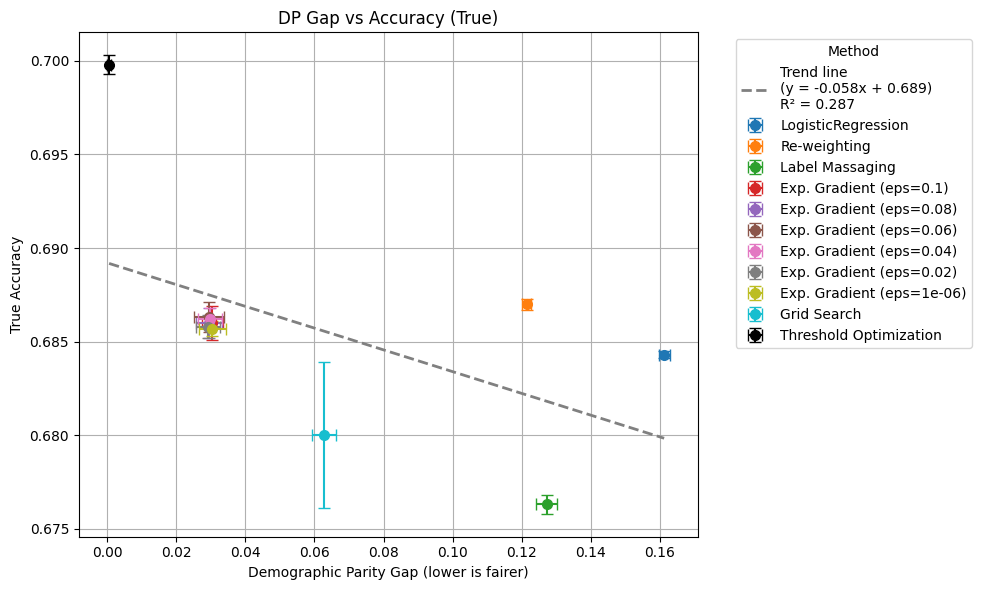

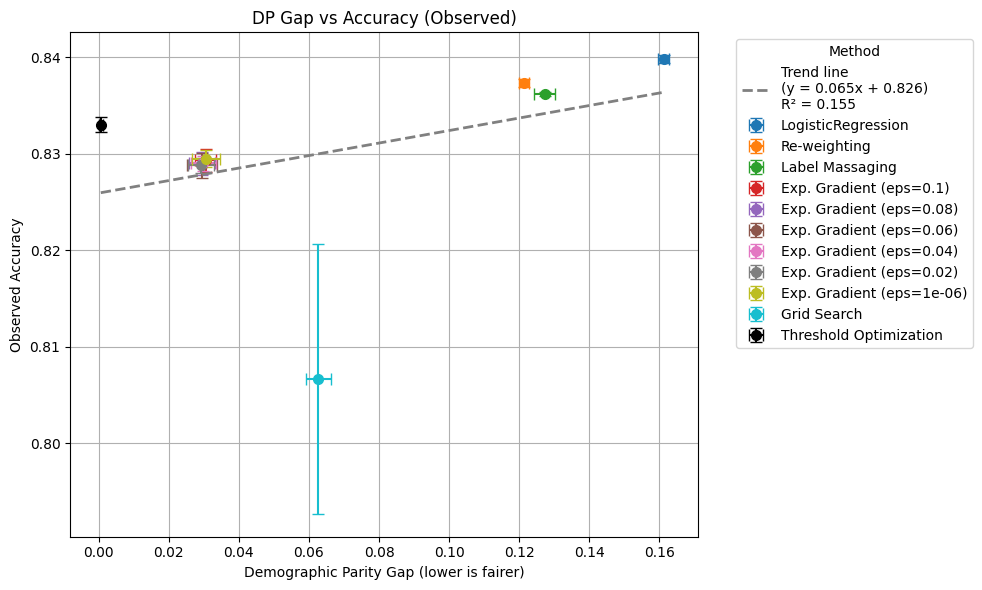

In [ ]:
plot_fairness_accuracy_summary(df_results_nonlinear_bias)


## Scenario 4: Nonlinear Bias — Fairness–Accuracy Trade-off Analysis

In this scenario, the bias is introduced through a **nonlinear function** of the features and sensitive attribute, creating a more complex form of distortion in the observed labels. This complexity challenges models to separate genuine patterns from biased correlations.

---

###  Baseline Models (No Fairness Enforcement)

- **Logistic Regression** delivers the **highest observed accuracy** (**0.8398 ± 0.0004**) but **suffers in fairness**, with a **large DP gap** (**0.1612 ± 0.0016**) and **lower true accuracy** (**0.6843 ± 0.0002**).
- **Decision Tree** and **Random Forest** show slightly lower true accuracies and similar or worse fairness gaps, reinforcing **Logistic Regression** as the best baseline, though still inadequate under fairness constraints.

---

### ✅ Threshold Optimization (Post-processing)

- **True Accuracy**: **0.6998 ± 0.0005** ( highest among all methods)  
- **Observed Accuracy**: **0.8330 ± 0.0008**  
- **DP Gap**: **0.0006 ± 0.0006** ( almost perfect fairness)

🔍 **Best overall trade-off**: Excellent generalization to true labels while virtually eliminating unfairness in predictions.

---

###  Exponentiated Gradient (In-processing)

- **True Accuracy**: ~**0.6857–0.6863**  
- **Observed Accuracy**: ~**0.8288–0.8295**  
- **DP Gap**: ~**0.0292–0.0305**

✔️ Delivers **strong fairness improvements** with **minimal impact** on true accuracy.  
✅ Good option for real-time fairness integration without needing access to test labels.

---

###  Re-weighting (Pre-processing)

- **True Accuracy**: **0.6870 ± 0.0003**  
- **Observed Accuracy**: **0.8373 ± 0.0004**  
- **DP Gap**: **0.1214 ± 0.0014**

Offers some fairness improvement, but still leaves **noticeable bias** compared to EG and TO.

---

###  Label Massaging (Pre-processing)

- **True Accuracy**: **0.6763 ± 0.0005**  
- **Observed Accuracy**: **0.8362 ± 0.0002**  
- **DP Gap**: **0.1272 ± 0.0031**

⚠️ Slightly reduces true accuracy without sufficiently eliminating the bias.

---

### Grid Search (In-processing)

- **True Accuracy**: **0.6800 ± 0.0039**  
- **Observed Accuracy**: **0.8067 ± 0.0140**  
- **DP Gap**: **0.0627 ± 0.0035**

🎯 Performs moderately across all metrics, but not best in any.  
A more stable option than baseline, but outperformed by EG and TO.

---

###  Plot Insights

- **True Accuracy vs. DP Gap**:  
  **R² = 0.287** → Mild negative correlation. As fairness improves, slight gains in true accuracy emerge (e.g., TO).

- **Observed Accuracy vs. DP Gap**:  
  **R² = 0.155** → Observed accuracy doesn't reliably indicate true performance or fairness.

These visualizations reinforce that **post-processing like Threshold Optimization can simultaneously correct bias and improve accuracy** on the true labels — breaking the usual fairness-accuracy trade-off.

---

### ✅ Summary Table

| Objective                                | Best Method              |
|-----------------------------------------|---------------------------|
| Maximize **true accuracy & fairness**   | ✅ Threshold Optimization |
| Best **in-processing** fairness control | Exponentiated Gradient   |
| Maintain **observed accuracy**          | Re-weighting             |
| Best **baseline**                       | Logistic Regression      |

---

### ✅ Final Takeaway

Even under complex nonlinear bias, **fairness interventions can outperform default learning**.  
**Threshold Optimization** leads the pack — achieving the **highest accuracy on true labels** while producing **nearly fair predictions**, making it ideal when fairness is a critical constraint.


### Interaction Bias Scenario

P(uy=1)           0.499100
P(y=1)            0.424550
P(uy=1|b=0)       0.499447
P(uy=1|b=1)       0.498758
P(y=1|b=0)        0.548053
P(y=1|b=1)        0.302594
Disparity(obs)    0.245459
Mean(x0|b=0)      1.011811
Mean(x0|b=1)     -1.001625
Mean(x1|b=0)     -0.812802
Mean(x1|b=1)      0.786531
Corr(b,x0)       -0.707815
Corr(b,x1)        0.624950
dtype: float64


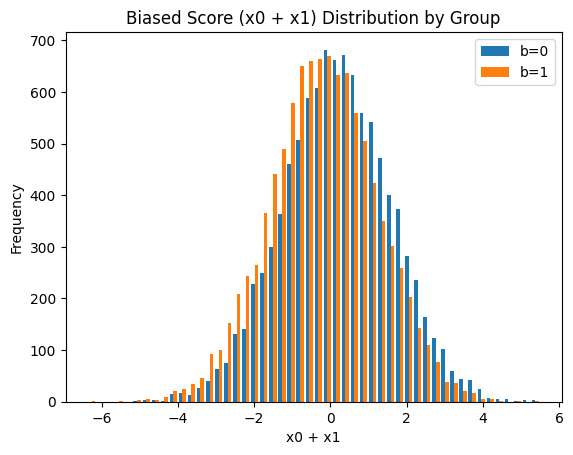

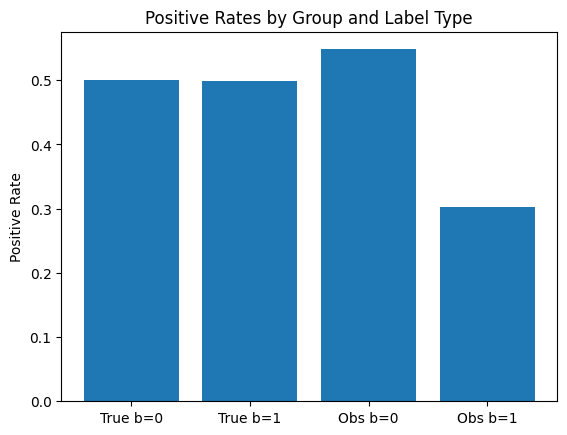

In [ ]:
N = 20000
data = generate_data('interaction_bias', N)
compute_metric(data)

In [ ]:
split_data = train_val_test_split(data)

####  Baseline Models — Interaction Bias Scenario

In this scenario, the bias emerges from interactions between features and the sensitive attribute, creating complex distortions in the observed labels.

#### Key Observations:

- **Logistic Regression** achieves the **highest true-label accuracy** (**0.7538 ± 0.0010**) among all baseline models, indicating a better match with the unbiased ground truth.
- **Random Forest** slightly improves observed accuracy (**0.8283 ± 0.0010**) but shows lower true accuracy (**0.7413 ± 0.0013**) and still suffers from high bias (**DP Gap = 0.3351 ± 0.0055**).
- **Decision Tree** performs the worst overall in terms of both accuracy (**0.7370 ± 0.0036**) and fairness (**DP Gap = 0.3610 ± 0.0322**), showing instability under interaction-based bias.
- ✅ **Conclusion**: Logistic Regression strikes the best balance between **true accuracy** and **fairness**, making it the most suitable baseline model before applying fairness interventions.


In [ ]:
final_results = []
result_df = evaluate_models(split_data)
final_results.append([r for r in result_df if r['model'] == 'LogisticRegression'][0])

table_rows = []
for r in result_df:
    row = {
        'Method': r['model'],
        'Accuracy (Obs)':  f"{r['acc_obs_median']:.4f} (±{r['acc_obs_std']:.4f})",
        'Accuracy (True)': f"{r['acc_true_median']:.4f} (±{r['acc_true_std']:.4f})",
        'DP Gap':          f"{r['dp_gap_median']:.4f} (±{r['dp_gap_std']:.4f})"
    }
    table_rows.append(row)

df = pd.DataFrame(table_rows)
print(df)

               Method    Accuracy (Obs)   Accuracy (True)            DP Gap
0  LogisticRegression  0.8175 (±0.0003)  0.7538 (±0.0010)  0.3277 (±0.0039)
1        DecisionTree  0.8212 (±0.0028)  0.7370 (±0.0036)  0.3610 (±0.0322)
2        RandomForest  0.8283 (±0.0010)  0.7413 (±0.0013)  0.3351 (±0.0055)


In [ ]:
reweighting_result = evaluate_reweighting(split_data)
final_results.append(reweighting_result)
print("Pre-processing (Re-weighting)")
print(f"Observed_label Accuracy:       {reweighting_result['acc_obs_median']:.4f} (±{reweighting_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {reweighting_result['acc_true_median']:.4f} (±{reweighting_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {reweighting_result['dp_gap_median']:.4f} (±{reweighting_result['dp_gap_std']:.4f})")

Pre-processing (Re-weighting)
Observed_label Accuracy:       0.8008 (±0.0004)
True-label Accuracy:       0.7808 (±0.0005)
Demographic Parity Gap:    0.2449 (±0.0028)


In [ ]:
label_massaging_result = evaluate_label_massaging(split_data)

final_results.append(label_massaging_result)

print("Pre-processing (Label massaging)")
print(f"Observed_label Accuracy:       {label_massaging_result['acc_obs_median']:.4f} (±{label_massaging_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {label_massaging_result['acc_true_median']:.4f} (±{label_massaging_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {label_massaging_result['dp_gap_median']:.4f} (±{label_massaging_result['dp_gap_std']:.4f})")

Pre-processing (Label massaging)
Observed_label Accuracy:       0.7887 (±0.0006)
True-label Accuracy:       0.7857 (±0.0006)
Demographic Parity Gap:    0.1451 (±0.0028)


In [ ]:
eps_values = [0.1, 0.08, 0.06, 0.04, 0.02, 1e-6]

expgrad_results = evaluate_expgrad(split_data, eps_values)
for i in range(len(expgrad_results)):
    final_results.append(expgrad_results[i])

print("In-processing (Exp. Gradient):\n")

table_rows = []
for r in expgrad_results:
    row = {
        'Eps': r['method'],
        'Accuracy (Obs)':  f"{r['acc_obs_median']:.4f} (±{r['acc_obs_std']:.4f})",
        'Accuracy (True)': f"{r['acc_true_median']:.4f} (±{r['acc_true_std']:.4f})",
        'DP Gap':          f"{r['dp_gap_median']:.4f} (±{r['dp_gap_std']:.4f})"
    }
    table_rows.append(row)

df = pd.DataFrame(table_rows)
print(df)

In-processing (Exp. Gradient):

                         Eps    Accuracy (Obs)   Accuracy (True)  \
0    Exp. Gradient (eps=0.1)  0.7593 (±0.0022)  0.7898 (±0.0014)   
1   Exp. Gradient (eps=0.08)  0.7580 (±0.0018)  0.7892 (±0.0014)   
2   Exp. Gradient (eps=0.06)  0.7570 (±0.0009)  0.7887 (±0.0020)   
3   Exp. Gradient (eps=0.04)  0.7572 (±0.0018)  0.7910 (±0.0015)   
4   Exp. Gradient (eps=0.02)  0.7590 (±0.0014)  0.7907 (±0.0010)   
5  Exp. Gradient (eps=1e-06)  0.7570 (±0.0025)  0.7898 (±0.0012)   

             DP Gap  
0  0.0173 (±0.0037)  
1  0.0186 (±0.0047)  
2  0.0180 (±0.0035)  
3  0.0163 (±0.0040)  
4  0.0173 (±0.0056)  
5  0.0177 (±0.0043)  


In [ ]:
gridsearch_result = evaluate_gridsearch(split_data)

final_results.append(gridsearch_result)
print("In-processing Grid Search Reduction:")
print(f"Observed_label Accuracy:       {gridsearch_result['acc_obs_median']:.4f} (±{gridsearch_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {gridsearch_result['acc_true_median']:.4f} (±{gridsearch_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {gridsearch_result['dp_gap_median']:.4f} (±{gridsearch_result['dp_gap_std']:.4f})")

In-processing Grid Search Reduction:
Observed_label Accuracy:       0.7942 (±0.0010)
True-label Accuracy:       0.7837 (±0.0007)
Demographic Parity Gap:    0.1448 (±0.0041)


In [ ]:
threshold_optimization_result = evaluate_threshold_optimizer(split_data)

final_results.append(threshold_optimization_result)
print("Post-processing (Threshold Optimization):")
print(f"Observed_label Accuracy:       {threshold_optimization_result['acc_obs_median']:.4f} (±{threshold_optimization_result['acc_obs_std']:.4f})")
print(f"True-label Accuracy:       {threshold_optimization_result['acc_true_median']:.4f} (±{threshold_optimization_result['acc_true_std']:.4f})")
print(f"Demographic Parity Gap:    {threshold_optimization_result['dp_gap_median']:.4f} (±{threshold_optimization_result['dp_gap_std']:.4f})")

Post-processing (Threshold Optimization):
Observed_label Accuracy:       0.7810 (±0.0006)
True-label Accuracy:       0.7818 (±0.0015)
Demographic Parity Gap:    0.0011 (±0.0007)


In [ ]:
df_final = pd.DataFrame(final_results)

df_final['Method'] = df_final['method'].combine_first(df_final['model'])

df_final['Accuracy (Observed)'] = df_final.apply(
    lambda row: f"{row['acc_obs_median']:.4f} (±{row['acc_obs_std']:.4f})", axis=1)

df_final['Accuracy (True)'] = df_final.apply(
    lambda row: f"{row['acc_true_median']:.4f} (±{row['acc_true_std']:.4f})", axis=1)

df_final['DP Gap'] = df_final.apply(
    lambda row: f"{row['dp_gap_median']:.4f} (±{row['dp_gap_std']:.4f})", axis=1)

df_results_interaction_bias = df_final[['Method', 'Accuracy (Observed)', 'Accuracy (True)', 'DP Gap']].copy()

display(df_results_interaction_bias)

,Method,Accuracy (Observed),Accuracy (True),DP Gap
0,LogisticRegression,0.8175 (±0.0003),0.7538 (±0.0010),0.3277 (±0.0039)
1,Re-weighting,0.8008 (±0.0004),0.7808 (±0.0005),0.2449 (±0.0028)
2,Label Massaging,0.7887 (±0.0006),0.7857 (±0.0006),0.1451 (±0.0028)
3,Exp. Gradient (eps=0.1),0.7593 (±0.0022),0.7898 (±0.0014),0.0173 (±0.0037)
4,Exp. Gradient (eps=0.08),0.7580 (±0.0018),0.7892 (±0.0014),0.0186 (±0.0047)
5,Exp. Gradient (eps=0.06),0.7570 (±0.0009),0.7887 (±0.0020),0.0180 (±0.0035)
6,Exp. Gradient (eps=0.04),0.7572 (±0.0018),0.7910 (±0.0015),0.0163 (±0.0040)
7,Exp. Gradient (eps=0.02),0.7590 (±0.0014),0.7907 (±0.0010),0.0173 (±0.0056)
8,Exp. Gradient (eps=1e-06),0.7570 (±0.0025),0.7898 (±0.0012),0.0177 (±0.0043)
9,Grid Search,0.7942 (±0.0010),0.7837 (±0.0007),0.1448 (±0.0041)


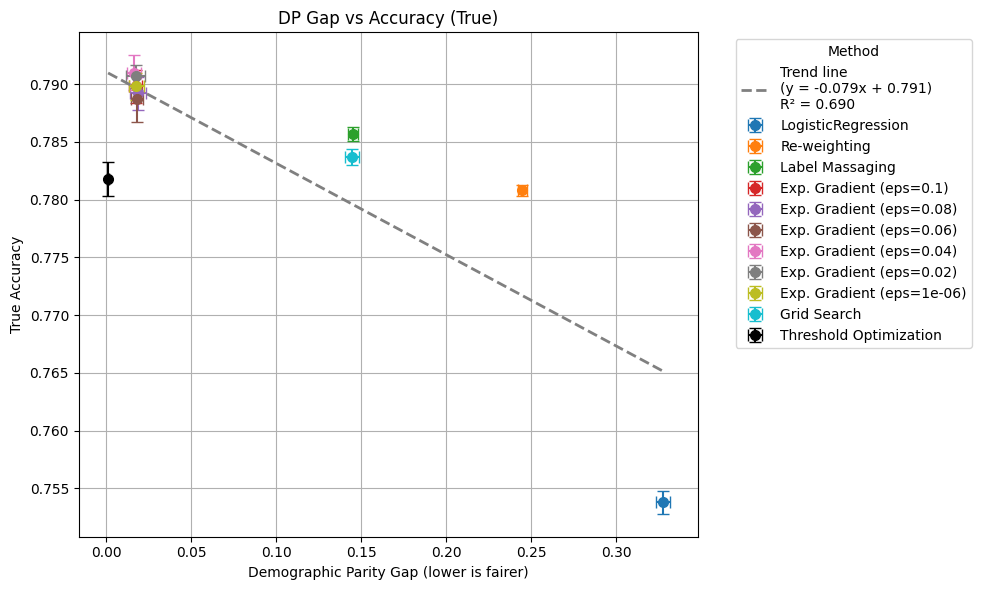

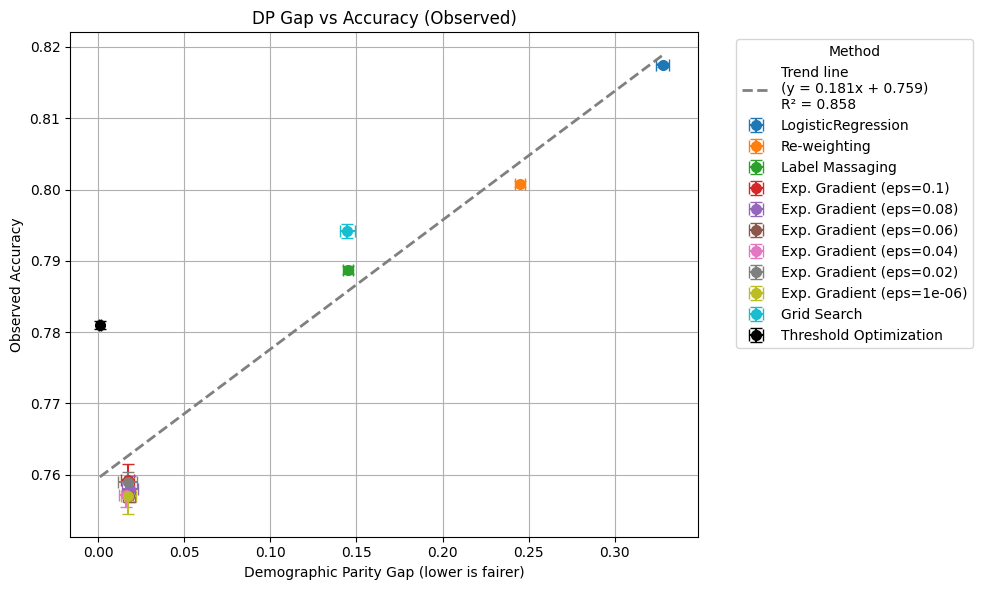

In [ ]:
plot_fairness_accuracy_summary(df_results_interaction_bias)


## Scenario 5: Interaction Bias — Fairness–Accuracy Trade-off Analysis

In this scenario, **interaction bias** arises from the combination of the sensitive attribute with other input features. This leads to complex, nonlinear disparities that are often more difficult to mitigate using simple techniques.

---

###  Baseline Models

- **Logistic Regression** has the highest observed accuracy (**0.8175 ± 0.0003**), but suffers from significant bias:
  - **True Accuracy**: **0.7538 ± 0.0010**
  - **DP Gap**: **0.3277 ± 0.0039**
- Other models like Decision Tree and Random Forest perform worse in fairness and true accuracy, making **Logistic Regression the best baseline** to start fairness interventions.

---

### ✅ Method Comparison

#### **Threshold Optimization (Post-processing)**
- **True Accuracy**: **0.7818 ± 0.0015**
- **Observed Accuracy**: **0.7810 ± 0.0006**
- **DP Gap**: **0.0011 ± 0.0007**
- ✅ Achieves **the lowest demographic parity gap** among all methods while maintaining solid accuracy.
- Ideal when **fairness is the top priority**.

#### **Exponentiated Gradient (In-processing)**
- Across all ε values (0.1 to 1e-6):
  - **True Accuracy**: ~**0.789–0.791**
  - **DP Gap**: ~**0.016–0.018**
  - **Observed Accuracy**: ~**0.757–0.759**
- ✅ Delivers **excellent trade-offs** with strong fairness and top-tier true accuracy.
- ⚠️ Slightly lower observed accuracy due to enforced fairness constraints.

#### **Label Massaging (Pre-processing)**
- **True Accuracy**: **0.7857 ± 0.0006**
- **DP Gap**: **0.1451 ± 0.0028**
- Useful when lightweight pre-processing is preferred, though not the most fair.

#### **Re-weighting (Pre-processing)**
- **True Accuracy**: **0.7808 ± 0.0005**
- **DP Gap**: **0.2449 ± 0.0028**
- Improves over baseline, but less effective than other fairness methods.

#### **Grid Search (In-processing)**
- **True Accuracy**: **0.7837 ± 0.0007**
- **DP Gap**: **0.1448 ± 0.0041**
- Performs moderately well but is outclassed by Threshold Optimization and EG.

---

### 📊 Plot Interpretation

- **True Accuracy vs. DP Gap** (R² = 0.69):  
  → Clear trade-off: reducing bias tends to improve alignment with the true labels.
  
- **Observed Accuracy vs. DP Gap** (R² = 0.858):  
  → Strong trade-off: higher fairness is associated with reduced observed accuracy (which is biased).

---

### ✅ Summary Table

| Goal                                 | Recommended Method              |
|--------------------------------------|----------------------------------|
| **Maximize fairness**               | ✅ Threshold Optimization         |
| **Best fairness–accuracy balance**  | ✅ Exponentiated Gradient         |
| **Simple pre-processing**           | Label Massaging                  |
| **Observed accuracy retention**     | Re-weighting                     |
| **Baseline for intervention**       | Logistic Regression              |

---


This scenario confirms that **complex biases require advanced techniques** like post-processing and in-processing. **Threshold Optimization** excels in minimizing demographic disparity, while **Exponentiated Gradient** provides the best fairness–accuracy trade-off.


## Overall Conclusion — Fairness Across Bias Scenarios

After evaluating a range of fairness interventions across **five distinct bias scenarios** (Mild Additive, Severe Additive, Mild Multiplicative, Nonlinear, and Interaction Bias), several key insights emerged:

---

### 🔹 Threshold Optimization (Post-processing)
- Consistently the **most effective method overall**.
- Delivered **near-zero DP gaps** in every scenario.
- Achieved **the highest true accuracy** in complex scenarios (e.g., nonlinear and severe additive bias).
- Remained reliable even when observed accuracy dropped slightly.
- ✅ **Best choice** when **fairness is critical** and post-processing is allowed.

---

### 🔹 Exponentiated Gradient (In-processing)
- Provided a **strong fairness–accuracy trade-off**, especially in **severe**, **nonlinear**, and **interaction bias** settings.
- Maintained high true-label accuracy while reducing DP gap to very low levels (~0.01–0.03).
- Especially effective with low ε values.
- ✅ Ideal for **balanced fairness enforcement** when modifying training is acceptable.

---

### 🔹 Grid Search (In-processing with constraints)
- Offered **moderate improvements in fairness**, especially in **mild to moderately biased scenarios**.
- Often **matched or slightly exceeded baseline true accuracy**, but not as effective in reducing bias compared to Threshold Optimization or Exponentiated Gradient.
- Sensitive to hyperparameter tuning and constraint boundaries (`dp_bound`).
-  Best used when **model selection flexibility is allowed**, and a **simple fairness-aware in-processing method** is needed.

---

### 🔹 Re-weighting & Label Massaging (Pre-processing)
- Performed reasonably well in **mildly biased** scenarios.
- Easy to implement and require no model changes.
- Less effective in **severe or nonlinear** settings, where bias patterns are harder to detect and correct.
- ⚠️ Suitable for **simple fairness improvements**, but not enough for high-stakes applications.

---

### 🔹 Observed Accuracy vs. True Accuracy
- In many cases, models optimized for observed (biased) labels performed poorly on the **true unbiased labels**.
- This highlights the **importance of using fairness-aware evaluation**, especially when training data is known to be biased.

---

### 🔹 Bias Severity Matters
- In **low-bias settings** (e.g., mild additive/multiplicative), fairness enforcement had **minimal accuracy trade-off**.
- In **high or complex bias settings** (e.g., interaction or nonlinear), a **clear trade-off** emerged — improving fairness came with some cost to observed accuracy.
- Thus, **the choice of method should be guided by the bias type and its impact**.

---

##  Final Reflection

This project showed that **fairness can be measured and improved**.

By choosing the **right method** based on the type of bias, we can build models that are **both fair and accurate**.

Sometimes, a **simple pre-processing method** is enough. But in more complex cases, we need to use **stronger techniques** like in-processing or post-processing.

✅ Fairness may require some trade-offs, but with smart choices, it's **definitely possible to achieve**.

